# PREPROCESSING

ATTENTION-LSTM Forecasting with VMD Decomposition on ETTh1 Dataset

In this experiment, we use the ETTh1 dataset (Electricity Transformer Temperature, hourly data) to forecast the oil temperature (OT).
We first apply **Variational Mode Decomposition (VMD)** to extract intrinsic mode components (IMFs) from the `OT` series, 
then use an **Attention-based LSTM (Attn-LSTM)** to capture temporal dependencies and focus on informative time steps.



## Import-Params-Read-Visualization

In [68]:
# Parameters
SEQ_LEN = 24  # past 24 hours for each sample
TARGET_COL = "OT"  # target variable: Oil Temperature
FEATURE_COLS = ["OT", "HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]
EPOCHS = 50
BATCH_SIZE = 32

# VMD parameters
DC = 0  # no DC part imposed
init = 1  # initialize omegas uniformly
tol = 1e-7
K = 4  # number of VMD modes (tuneable)
alpha = 1705  # VMD alpha (tuneable)
tau = 0.05805898025979961  # VMD tau

LSTM_UNITS = 128
DROPOUT = 0.2
LEARNING_RATE = 1e-2

In [2]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.layers import (
    LSTM,
    Attention,
    Bidirectional,
    Concatenate,
    Dense,
    Dropout,
    Input,
    Lambda,
    Layer,
    LayerNormalization,
    MultiHeadAttention,
    RepeatVector,
    Reshape,
    Softmax,
)
from tensorflow.keras.losses import mse
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from vmdpy import VMD

2025-12-20 10:24:12.760548: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-20 10:24:12.883229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766213652.942827    4506 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766213652.957399    4506 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766213653.056853    4506 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
save_dir = os.path.expanduser("~/Project/Nested_Attention_BiLSTM_VMD/data/raw")
os.makedirs(save_dir, exist_ok=True)
# Full file path
file_path = os.path.join(save_dir, "ETTh1.csv")
# Load it whenever needed
df = pd.read_csv(file_path)
print(df.head())
df.columns = df.columns.str.strip().str.replace("\ufeff", "")
print(df.columns)
# Ensure datetime type
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
data = df[[TARGET_COL]].values

                  date   HUFL   HULL   MUFL   MULL   LUFL   LULL         OT
0  2016-07-01 00:00:00  5.827  2.009  1.599  0.462  4.203  1.340  30.531000
1  2016-07-01 01:00:00  5.693  2.076  1.492  0.426  4.142  1.371  27.787001
2  2016-07-01 02:00:00  5.157  1.741  1.279  0.355  3.777  1.218  27.787001
3  2016-07-01 03:00:00  5.090  1.942  1.279  0.391  3.807  1.279  25.044001
4  2016-07-01 04:00:00  5.358  1.942  1.492  0.462  3.868  1.279  21.948000
Index(['date', 'HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT'], dtype='object')


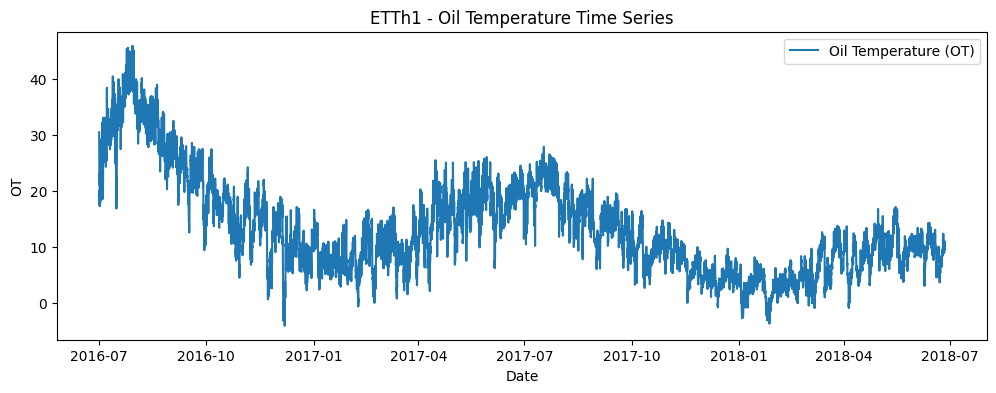

In [4]:
# Visualize
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["OT"], label="Oil Temperature (OT)")
plt.title("ETTh1 - Oil Temperature Time Series")
plt.xlabel("Date")
plt.ylabel("OT")
plt.legend()
plt.show()

## X,Y  and Train_test_split Simple

In [5]:
# =====================================================
# Split Train / Test
# =====================================================
split_idx = int(len(df) * 0.8)

X = df[FEATURE_COLS].values
y = df[TARGET_COL].values.reshape(-1, 1)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# =====================================================
# Column indices
# =====================================================
ot_idx = FEATURE_COLS.index(TARGET_COL)
other_feature_indices = [i for i, c in enumerate(FEATURE_COLS) if c != TARGET_COL]

# =====================================================
# VMD + sequence creator (OT only)
# =====================================================
def create_sequences_ot_vmd_only(X, y, seq_len, alpha, tau, K, ot_idx, other_idxs):
    Xs, ys = [], []

    for i in range(len(X) - seq_len):
        seq_x = X[i : i + seq_len]  # (seq_len, num_features)
        seq_y = y[i + seq_len]

        # --- VMD on OT only ---
        ot_signal = seq_x[:, ot_idx]
        if alpha > 0 and K > 1:
            u, _, _ = VMD(ot_signal, alpha, tau, K, DC=0, init=1, tol=1e-7)
            ot_vmd = np.stack(u, axis=1)  # (seq_len, K)
        else:
            ot_vmd = ot_signal.reshape(seq_len, 1)

        # --- Other features (raw) ---
        other_feats = seq_x[:, other_idxs]

        # --- Concatenate ---
        seq_x_final = np.concatenate([ot_vmd, other_feats], axis=1)

        Xs.append(seq_x_final)
        ys.append(seq_y)

    return np.array(Xs), np.array(ys)


# =====================================================
# Create sequences (train / test)
# =====================================================
X_train_vmd_seq, y_train_vmd_seq = create_sequences_ot_vmd_only(
    X_train, y_train, SEQ_LEN, alpha, tau, K, ot_idx, other_feature_indices
)

X_test_vmd_seq, y_test_vmd_seq = create_sequences_ot_vmd_only(
    X_test, y_test, SEQ_LEN, alpha, tau, K, ot_idx, other_feature_indices
)

# =====================================================
# Scaling
# =====================================================
# Separate scalers for X (features) and Y (target)
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# --- Prepare X ---
num_train, seq_len, feat_dim = X_train_vmd_seq.shape
num_test = X_test_vmd_seq.shape[0]
ot_vmd_dim = K
n_other = feat_dim - K

# Split OT-VMD and other features
X_train_ot_vmd = X_train_vmd_seq[:, :, :ot_vmd_dim].reshape(-1, ot_vmd_dim)
X_train_other = X_train_vmd_seq[:, :, ot_vmd_dim:].reshape(-1, n_other)

X_test_ot_vmd = X_test_vmd_seq[:, :, :ot_vmd_dim].reshape(-1, ot_vmd_dim)
X_test_other = X_test_vmd_seq[:, :, ot_vmd_dim:].reshape(-1, n_other)

# Fit scaler on TRAIN only
scaler_x.fit(np.concatenate([X_train_ot_vmd, X_train_other], axis=1))
scaler_y.fit(y_train_vmd_seq)

# Transform
X_train_vmd_scaled = scaler_x.transform(
    np.concatenate([X_train_ot_vmd, X_train_other], axis=1)
).reshape(num_train, seq_len, feat_dim)

X_test_vmd_scaled = scaler_x.transform(
    np.concatenate([X_test_ot_vmd, X_test_other], axis=1)
).reshape(num_test, seq_len, feat_dim)

y_train_vmd_scaled = scaler_y.transform(y_train_vmd_seq.reshape(-1, 1)).flatten()
y_test_vmd_scaled = scaler_y.transform(y_test_vmd_seq.reshape(-1, 1)).flatten()

# =====================================================
# Optional: inverse transform for evaluation
# =====================================================
y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd_scaled.reshape(-1, 1)).flatten()

# =====================================================
# simple sequences without VMD
# =====================================================
x_scaler_simple = MinMaxScaler()
X_train_scaled = x_scaler_simple.fit_transform(X_train)
X_test_scaled = x_scaler_simple.transform(X_test)
y_scaler_simple = MinMaxScaler()
y_train_scaled = y_scaler_simple.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler_simple.transform(y_test.reshape(-1, 1))


def create_sequences_noVMD(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i : i + seq_len])
        ys.append(y[i + seq_len])
    return np.array(Xs), np.array(ys)


X_train_simple, y_train_simple = create_sequences_noVMD(
    X_train_scaled, y_train_scaled, SEQ_LEN
)
X_test_simple, y_test_simple = create_sequences_noVMD(
    X_test_scaled, y_test_scaled, SEQ_LEN
)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple.reshape(-1, 1)).flatten()
sum(y_test_vmd_true - y_test_simple_true)

/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/vmdpy/vmdpy.py:114: RuntimeWarning: invalid value encountered in scalar divide
  omega_plus[n+1,k] = np.dot(freqs[T//2:T],(abs(u_hat_plus[n+1, T//2:T, k])**2))/np.sum(abs(u_hat_plus[n+1,T//2:T,k])**2)
/opt/anaconda3/envs/tf-gpu2/lib/python3.11/site-packages/vmdpy/vmdpy.py:112: RuntimeWarning: invalid value encountered in divide
  u_hat_plus[n+1,:,k] = (f_hat_plus - sum_uk - lambda_hat[n,:]/2)/(1+Alpha[k]*(freqs - omega_plus[n,k])**2)


np.float64(0.0)

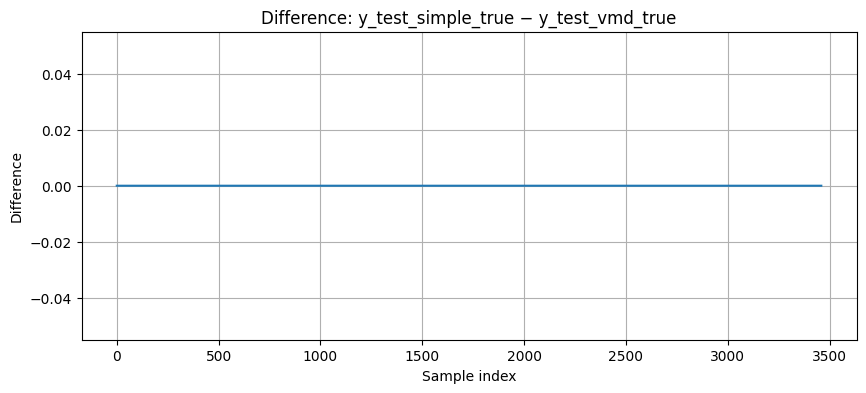

In [6]:
diff = y_test_simple_true.squeeze() - y_test_vmd_true.squeeze()

plt.figure(figsize=(10, 4))
plt.plot(diff)
plt.title("Difference: y_test_simple_true − y_test_vmd_true")
plt.xlabel("Sample index")
plt.ylabel("Difference")
plt.grid(True)
plt.show()

## CUSTOM LAYERS

In [73]:
# ===================================================
# PERFORMER ATTENTION
# ===================================================
class PerformerAttention(Layer):
    def __init__(self, num_heads, model_dim, kernel_eps=1e-6, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.kernel_eps = kernel_eps
        self.dropout = Dropout(dropout)
        self.head_dim = model_dim // num_heads
        assert model_dim % num_heads == 0, "model_dim must be divisible by num_heads"

    def build(self, input_shape):
        # Linear projections
        self.Wq = Dense(self.model_dim)
        self.Wk = Dense(self.model_dim)
        self.Wv = Dense(self.model_dim)
        self.Wo = Dense(self.model_dim)

        # Random Gaussian projection for FAVOR+
        self.proj = self.add_weight(
            shape=(self.head_dim, self.head_dim),
            initializer="random_normal",
            trainable=False,
            name="proj_matrix",
        )

    def kernel(self, x):
        # FAVOR+ kernel Φ(x)
        x_proj = tf.einsum("...nd,df->...nf", x, self.proj)
        return tf.nn.relu(x_proj) + self.kernel_eps

    def split_heads(self, x):
        B = tf.shape(x)[0]
        T = tf.shape(x)[1]
        x = tf.reshape(x, (B, T, self.num_heads, self.head_dim))
        return tf.transpose(x, [0, 2, 1, 3])  # (B, H, T, Dh)

    def merge_heads(self, x):
        B = tf.shape(x)[0]
        T = tf.shape(x)[2]
        x = tf.transpose(x, [0, 2, 1, 3])
        return tf.reshape(x, (B, T, self.model_dim))

    def call(self, x, training=False):
        Q, K, V = x  # all shape (B, T, model_dim)

        # Linear projections + split heads
        Q = self.split_heads(self.Wq(Q))
        K = self.split_heads(self.Wk(K))
        V = self.split_heads(self.Wv(V))

        # FAVOR+ kernel
        Q_phi = self.kernel(Q)  # (B, H, T, Dh)
        K_phi = self.kernel(K)

        # Compute KV and normalization
        KV = tf.einsum("bhnd,bhne->bhde", K_phi, V)  # (B,H,Dh,Dh)
        Z = 1.0 / (
            tf.einsum("bhnd,bhd->bhn", Q_phi, tf.reduce_sum(K_phi, axis=2)) + 1e-6
        )
        out = tf.einsum("bhnd,bhde,bhn->bhne", Q_phi, KV, Z)

        # Merge heads
        out = self.merge_heads(out)
        return self.Wo(out)


# ===================================================
# VAE SAMPLING LAYER
# ===================================================
class KLDivergenceLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        kl = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
        self.add_loss(kl)
        return inputs


class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mu, log_var = inputs
        eps = tf.random.normal(tf.shape(mu))
        return mu + tf.exp(0.5 * log_var) * eps


# =====================================================
# 2️⃣ Bahdanau-style Attention Layer
# =====================================================
class AttentionLayer_Bahdanau(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer_Bahdanau, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer="glorot_uniform",
            trainable=True,
            name="att_weight",
        )
        self.b = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="att_bias",
        )
        self.u = self.add_weight(
            shape=(input_shape[-1],),
            initializer="glorot_uniform",
            trainable=True,
            name="context_vector",
        )
        super(AttentionLayer_Bahdanau, self).build(input_shape)

    def call(self, x):
        # x shape: (batch, time_steps, features)
        u_it = tf.tanh(
            tf.tensordot(x, self.W, axes=1) + self.b
        )  # (batch, time, features)
        a_it = tf.tensordot(u_it, self.u, axes=1)  # (batch, time)
        a_it = tf.nn.softmax(a_it, axis=1)  # (batch, time)
        a_it = tf.expand_dims(a_it, axis=-1)  # (batch, time, 1)
        weighted_output = x * a_it  # (batch, time, features)
        return tf.reduce_sum(weighted_output, axis=1)  # (batch, features)

    def compute_output_shape(self, input_shape):
        # output shape: (batch, features)
        return (input_shape[0], input_shape[2])


def build_attlstm_model(
    input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3
):
    inp = Input(shape=input_shape)

    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)

    # Attention
    att_out = AttentionLayer_Bahdanau()(x)

    # Decoder LSTM
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)

    # Dense layers
    x = Dense(dense_units, activation="relu")(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss="mse", metrics=["mae"])
    return model


# ========================================
# 📌     LSTM + Residual Connection + LayerNorm
# ========================================
class LSTM_residual_norm(Layer):
    def __init__(self, units, dropout=0.1, **kwargs):
        super(LSTM_residual_norm, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout

        self.lstm = LSTM(units, return_sequences=True)
        self.dropout_layer = Dropout(dropout)
        self.norm = LayerNormalization()

    def build(self, input_shape):
        input_dim = input_shape[-1]  # <-- Detect feature count automatically

        # Projection for residual connection
        self.proj = Dense(self.units)  # input_dim → units

        super().build(input_shape)

    def call(self, x):
        h = self.lstm(x)
        h = self.dropout_layer(h)

        h_res = self.proj(x)  # Now works for any feature dimension

        return self.norm(h + h_res)


# ========================================
# 📌  Attention(Bahdanau) + LSTM + Residual Connection + LayerNorm
# ========================================
def build_att_customlstm_model(
    input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3
):
    inp = Input(shape=input_shape)

    # Encoder LSTM
    x = LSTM_residual_norm(lstm1_units)(inp)
    x = Dropout(dropout)(x)

    # Attention
    att_out = AttentionLayer_Bahdanau()(x)

    # Decoder LSTM
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM_residual_norm(lstm2_units)(x)
    x = Dropout(dropout)(x)

    # Dense layers
    x = Dense(dense_units, activation="relu")(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(lr), loss="mse", metrics=["mae"])
    return model


# =========================================================
# 📌  Custom Luong Attention
# score = h_t · W · h_s  (dot-product)
# =========================================================
class LuongAttention(Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.Wq = Dense(units)
        self.Wv = Dense(units)

    def call(self, query, value, mask=None):
        # Project both → SAME dimension
        q = self.Wq(query)  # (B, T, units)
        v = self.Wv(value)  # (B, T, units)

        # Dot product score
        score = tf.matmul(q, v, transpose_b=True)  # (B, T, T)

        if mask is not None:
            score += mask * -1e9

        # Use tf.nn.softmax (Keras-safe)
        attn_weights = tf.nn.softmax(score, axis=-1)  # (B, T, T)
        context = tf.matmul(attn_weights, v)  # (B, T, units)

        return context


# =========================================================
# 📌  Temporal Attention (per timestep)
# =========================================================
class TemporalAttention(Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        # input_shape = (batch, timesteps, features)
        d = input_shape[-1]

        self.Wt = Dense(self.units, activation="tanh")
        self.vt = Dense(1)

    def call(self, x):
        # score shape -> (batch, timesteps, units)
        h = self.Wt(x)

        # score shape -> (batch, timesteps, 1)
        score = self.vt(h)

        # attention weights
        alpha = tf.nn.softmax(score, axis=1)

        # weighted sum (batch, timesteps, features) -> (batch, features)
        context = tf.reduce_sum(alpha * x, axis=1)

        return context


def build_Tattlstm_model(
    input_shape, lstm1_units=128, lstm2_units=64, dense_units=32, dropout=0.2, lr=1e-3
):

    inp = Input(shape=input_shape)

    # Encoder LSTM
    x = LSTM(lstm1_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)

    # Temporal Attention
    att_out = TemporalAttention(units=lstm1_units)(x)

    # Decoder LSTM - convert context vector to sequence again
    x = Reshape((1, lstm1_units))(att_out)
    x = LSTM(lstm2_units, return_sequences=False)(x)
    x = Dropout(dropout)(x)

    # Dense layers
    x = Dense(dense_units, activation="relu")(x)
    out = Dense(1)(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(learning_rate=lr), loss="mse", metrics=["mae"])
    return model


# =========================================================
# 📌  Cross-Attention (Query from XLSTM, Key/Value from VMD input)
# =========================================================
class CrossAttention(Layer):
    def __init__(self, num_heads=4, key_dim=32):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, query, context, mask=None):
        return self.mha(query=query, value=context, key=context, attention_mask=mask)


# =========================================================
# 📌  Causal Masking (prevent future leakage)
# =========================================================
def causal_mask(seq_len):
    mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return mask[None, None, :, :]


# =========================================================
# 📌  InceptionTime block (1D, residual, multi-scale)
# =========================================================
def inception_time_block(x, filters=64, bottleneck=32):
    shortcut = x

    # Bottleneck (1x1 conv)
    if x.shape[-1] > bottleneck:
        x = Conv1D(bottleneck, kernel_size=1, padding="same", activation="relu")(x)

    # Parallel convolutions (same temporal length)
    conv1 = Conv1D(filters, 3, padding="same", activation="relu")(x)
    conv2 = Conv1D(filters, 5, padding="same", activation="relu")(x)
    conv3 = Conv1D(filters, 7, padding="same", activation="relu")(x)

    # 🔑 Pooling MUST preserve length + project channels
    pool = MaxPooling1D(pool_size=3, strides=1, padding="same")(x)  # 🔥 critical
    pool = Conv1D(filters, 1, padding="same", activation="relu")(pool)

    # Concatenate (now shapes match)
    x = Concatenate()([conv1, conv2, conv3, pool])
    x = BatchNormalization()(x)

    # Residual connection
    shortcut = Conv1D(x.shape[-1], 1, padding="same")(shortcut)
    x = Add()([x, shortcut])
    x = Activation("relu")(x)

    return x


# =========================================================
# 📌   TCN++ block (dilated, residual)
# =========================================================
def tcn_block(x, filters=64, kernel_size=3, dilation=1, dropout=0.1):
    shortcut = x

    x = Conv1D(
        filters, kernel_size, dilation_rate=dilation, padding="same", activation="relu"
    )(x)
    x = Dropout(dropout)(x)

    x = Conv1D(
        filters, kernel_size, dilation_rate=dilation, padding="same", activation="relu"
    )(x)

    shortcut = Conv1D(filters, 1, padding="same")(shortcut)
    x = Add()([x, shortcut])
    x = LayerNormalization()(x)

    return x


# =========================================================
# 📌  TFT Multi-Head Temporal self-Attention Layer (Keras)
#     this is a valid implementation of the temporal self-attention block inspired by the TFT paper:
#     Multi-head scaled dot-product attention
#     Decoder state as query
#     Encoder outputs as key/value
#     Layer norm + residual
#     Optional causal masking
#     It is simplified (no gating via GRN or VSN), but the attention math is correct and aligned with Transformer/TFT definitions.
# =========================================================
class TFTTemporalAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, model_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.model_dim = model_dim
        self.dropout_rate = dropout_rate

        assert model_dim % num_heads == 0
        self.depth = model_dim // num_heads

        self.Wq = Dense(model_dim)
        self.Wk = Dense(model_dim)
        self.Wv = Dense(model_dim)

        self.dense = Dense(model_dim)
        self.dropout = Dropout(dropout_rate)

    def split_heads(self, x):
        # (B, T, D) → (B, H, T, D/H)
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def build(self, input_shape):
        # input_shape = (B, T, D)
        self.Wq.build(input_shape)
        self.Wk.build(input_shape)
        self.Wv.build(input_shape)
        self.dense.build(input_shape)
        super().build(input_shape)

    def call(self, x, training=None):
        q = self.split_heads(self.Wq(x))
        k = self.split_heads(self.Wk(x))
        v = self.split_heads(self.Wv(x))

        scale = tf.math.sqrt(tf.cast(self.depth, tf.float32))
        scores = tf.matmul(q, k, transpose_b=True) / scale
        weights = tf.nn.softmax(scores, axis=-1)

        weights = self.dropout(weights, training=training)
        att = tf.matmul(weights, v)

        att = tf.transpose(att, perm=[0, 2, 1, 3])
        batch_size = tf.shape(att)[0]
        att = tf.reshape(att, (batch_size, -1, self.model_dim))

        return self.dense(att)


def build_TFTattlstm_model(
    input_shape,
    lstm1_units=100,
    lstm2_units=100,
    dense_units=32,
    model_dim=64,
    dropout=0.1,
):

    # Input
    encoder_inputs = Input(shape=input_shape)

    # Encoder
    enc_out = LSTM(lstm1_units, return_sequences=True)(encoder_inputs)
    enc_out = Dropout(dropout)(enc_out)
    enc_out = Dense(model_dim)(enc_out)
    enc_out = LayerNormalization()(enc_out)

    # Bahdanau Attention on encoder
    bahdanau_att_enc = AttentionLayer_Bahdanau()(enc_out)

    # Decoder
    dec_input = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_enc)
    dec_out = LSTM(lstm2_units, return_sequences=True)(dec_input)
    dec_out = Dropout(dropout)(dec_out)
    dec_out = Dense(model_dim)(dec_out)
    dec_out = LayerNormalization()(dec_out)

    # Bahdanau Attention on decoder
    bahdanau_att_dec = AttentionLayer_Bahdanau()(dec_out)

    # Final Dense Output
    x = Dense(dense_units, activation="relu")(bahdanau_att_dec)
    output = Dense(1)(x)

    # Build model
    model = Model(inputs=encoder_inputs, outputs=output, name="TFT_Att_LSTM_Bahdanau")
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model


def build_TFTattlstm_model2(
    input_shape,
    lstm1_units=100,
    lstm2_units=100,
    dense_units=32,
    num_heads=8,
    model_dim=64,
    dropout=0.1,
):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)

    # -------------------------
    # 1. Encoder LSTM
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group1 = Dropout(dropout)(group1)

    # -------------------------
    # 1b. Bahdanau Attention applied to encoder
    # -------------------------
    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(
        bahdanau_att_group1
    )

    # -------------------------
    # 2. Decoder LSTM
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group2 = Dropout(dropout)(group2)

    # Bahdanau attention over decoder
    bahdanau_att_group2 = AttentionLayer_Bahdanau()(group2)
    bahdanau_att_group2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(
        bahdanau_att_group2
    )

    # -------------------------
    # 3. TFT Multi-Head Attention Stack
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([bahdanau_att_group1, bahdanau_att_group2])

    # -------------------------
    # 4. Dense output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 5. Model compile
    # -------------------------
    model = Model(input_group, output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])

    return model


def build_TFTattlstm_model3(
    input_shape=(24, 8),
    lstm1_units=100,
    dense_units=32,
    num_heads=8,
    model_dim=64,
    dropout=0.1,
):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)  # (24, 8)

    # -------------------------
    # **Split input: group1 = first 4 features, group2 = next 4**
    # -------------------------
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)  # (24, 4)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)  # (24, 4)
    # -------------------------
    # 1. Encoder LSTM for Group 1
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)

    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(
        bahdanau_att_group1
    )
    # -------------------------
    # 2. Encoder LSTM for Group 2
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)

    bahdanau_att_group2 = AttentionLayer_Bahdanau()(group2)
    bahdanau_att_group2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(
        bahdanau_att_group2
    )
    # -------------------------
    # 3. TFT Multi-Head Temporal Attention
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([bahdanau_att_group1, bahdanau_att_group2])
    # -------------------------
    # 4. Dense Output
    # -------------------------
    output = Dense(1)(att_out)
    # -------------------------
    # 5. Compile Model
    # -------------------------
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])

    return model


# ============================
# BUILD Performer attlstm MODEL WITH cross attention
# ============================


def build_TFTattlstm_model4(
    input_shape=(24, 8),
    lstm1_units=100,
    dense_units=32,
    num_heads=8,
    model_dim=64,
    dropout=0.1,
):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)  # (24, 8)

    # -------------------------
    # Split input
    # -------------------------
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)

    # -------------------------
    # 1. Encoder LSTM for Group 1
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)
    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(
        bahdanau_att_group1
    )

    # -------------------------
    # 2. Encoder LSTM for Group 2
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)
    bahdanau_att_group2 = AttentionLayer_Bahdanau()(group2)
    bahdanau_att_group2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(
        bahdanau_att_group2
    )

    # -------------------------
    # 3. Cross Attention
    # -------------------------
    cross = CrossAttention(num_heads=num_heads, key_dim=model_dim)

    g1_to_g2 = cross(query=bahdanau_att_group1, context=bahdanau_att_group2)
    g2_to_g1 = cross(query=bahdanau_att_group2, context=bahdanau_att_group1)
    cross_out = Concatenate(axis=1)(
        [g1_to_g2, g2_to_g1]
    )  # shape: (batch, 2, model_dim)

    # -------------------------
    # 4. Multi-Head Attention (replaces Performer)
    # -------------------------
    mha = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)
    att_out = mha(query=cross_out, value=cross_out, key=cross_out)
    att_out = Dropout(dropout)(att_out)
    att_out = LayerNormalization(epsilon=1e-6)(att_out)

    # -------------------------
    # 5. LSTM + Output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 6. Model
    # -------------------------
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])

    return model


# ============================
# BUILD TFTattlstm MODEL WITH VAE
# ============================
def build_TFTattlstm_model5(
    input_shape=(24, 8),
    lstm1_units=100,
    dense_units=32,
    latent_dim=16,
    num_heads=8,
    model_dim=64,
    dropout=0.1,
):

    # -------------------------
    # 0. Input
    # -------------------------
    input_group = Input(shape=input_shape)

    # -------------------------
    # 1. Split Inputs
    # -------------------------
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)

    # -------------------------
    # 2. LSTM + Bahdanau Group1
    # -------------------------
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)
    bahdanau1 = AttentionLayer_Bahdanau()(group1)
    bahdanau1 = Lambda(lambda x: tf.expand_dims(x, 1))(bahdanau1)

    # -------------------------
    # 3. LSTM + Bahdanau Group2
    # -------------------------
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)
    bahdanau2 = AttentionLayer_Bahdanau()(group2)
    bahdanau2 = Lambda(lambda x: tf.expand_dims(x, 1))(bahdanau2)

    # -------------------------
    # 4. CONCAT Bahdanau outputs
    # -------------------------
    combined = Concatenate(axis=1)([bahdanau1, bahdanau2])  # (batch, 2, features)

    # -------------------------
    # 5. Flatten for VAE Encoder
    # -------------------------
    flat = Flatten()(combined)
    flat_dim = flat.shape[-1]  # static

    # -------------------------
    # 6. VAE Encoder
    # -------------------------
    mu = Dense(latent_dim)(flat)
    log_var = Dense(latent_dim)(flat)

    # Apply KL divergence correctly
    mu, log_var = KLDivergenceLayer()([mu, log_var])

    # Sampling
    z = Sampling()([mu, log_var])

    # -------------------------
    # 7. VAE Decoder
    # -------------------------
    decoder_hidden = Dense(64, activation="relu")(z)
    decoder_out = Dense(flat_dim, activation="linear")(decoder_hidden)

    decoder_out_reshaped = Reshape((2, flat_dim // 2))(decoder_out)

    # -------------------------
    # 8. TFT Multi-Head Temporal Attention
    # -------------------------
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)
    att_out = att_layer([decoder_out_reshaped, decoder_out_reshaped])

    # -------------------------
    # 9. LSTM + Dense Output
    # -------------------------
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # -------------------------
    # 10. Final Model
    # -------------------------
    model = Model(inputs=input_group, outputs=output)

    model.compile(optimizer="adam", loss="mse", metrics=["mae"])

    return model


# ============================
# BUILD TFTattlstm MODEL WITH PERFORMER
# ============================
def build_TFTattlstm_model6(
    input_shape=(24, 8),
    lstm1_units=64,
    dense_units=8,
    num_heads=8,
    model_dim=64,
    dropout=0.1,
):

    # 0. Input
    input_group = Input(shape=input_shape)  # (seq_len, features)

    # 1. Split input
    group1_input = Lambda(lambda x: x[:, :, :6])(input_group)
    group2_input = Lambda(lambda x: x[:, :, 6:])(input_group)

    # 2. LSTM for group1
    group1 = LSTM(lstm1_units, return_sequences=True)(group1_input)
    group1 = Dropout(dropout)(group1)

    # 3. LSTM for group2
    group2 = LSTM(lstm1_units, return_sequences=True)(group2_input)
    group2 = Dropout(dropout)(group2)

    # 4. Performer Attention on each group
    performer_att_group1 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group1, group1, group1]
    )
    performer_att_group2 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group2, group2, group2]
    )

    # Take last time step for each group
    performer_att_group1 = Lambda(lambda x: x[:, -1, :], name="group1_last_step")(
        performer_att_group1
    )
    performer_att_group2 = Lambda(lambda x: x[:, -1, :], name="group2_last_step")(
        performer_att_group2
    )

    # 5. Concatenate
    cross_out = Concatenate()([performer_att_group1, performer_att_group2])

    # 6. Dense + Output
    x = Dense(dense_units, activation="relu")(cross_out)
    output = Dense(1)(x)

    # 7. Compile
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae"])

    return model


# ============================
# BUILD TFTattlstm MODEL WITH PERFORMER and BAHDANAU
# ============================
def build_TFTattlstm_model7(
    input_shape=(24, 8),
    lstm1_units=64,
    dense_units=8,
    num_heads=8,
    model_dim=64,
    dropout=0.1,
):

    # 0. Input
    input_group = Input(shape=input_shape)  # (seq_len, features)

    # 2. LSTM for group1
    group1 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group1 = Dropout(dropout)(group1)

    # 3. LSTM for group2
    group2 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group2 = Dropout(dropout)(group2)

    # 4. Bahdanau Attention for group1
    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    # Expand dims to match Performer output shape
    bahdanau_att_group1 = Lambda(
        lambda x: tf.expand_dims(x, axis=1), name="group1_bahdanau_expand"
    )(bahdanau_att_group1)
    # Take last step
    bahdanau_att_group1 = Lambda(lambda x: x[:, -1, :], name="group1_last_step")(
        bahdanau_att_group1
    )

    # 5. Performer Attention for group2
    performer_att_group2 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group2, group2, group2]
    )
    performer_att_group2 = Lambda(lambda x: x[:, -1, :], name="group2_last_step")(
        performer_att_group2
    )

    # 6. Concatenate
    cross_out = Concatenate()([bahdanau_att_group1, performer_att_group2])

    # 7. Dense + Output
    x = Dense(dense_units, activation="relu")(cross_out)
    output = Dense(1)(x)

    # 8. Compile
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss="mae", optimizer="adam", metrics=["mse"])

    return model


def build_TFTattlstm_model8(
    input_shape=(24, 8),
    lstm1_units=64,
    cnn_filters=64,
    cnn_kernel=3,
    dense_units=8,
    num_heads=8,
    model_dim=64,
    dropout=0.1,
):

    # =====================================================
    # 0. Input
    # =====================================================
    input_group = Input(shape=input_shape)  # (seq_len, features)

    # =====================================================
    # 1. Group 1: LSTM → CNN → Bahdanau Attention
    # =====================================================
    group1 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group1 = Dropout(dropout)(group1)

    group1 = Conv1D(
        filters=cnn_filters, kernel_size=cnn_kernel, padding="same", activation="relu"
    )(group1)
    group1 = BatchNormalization()(group1)

    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(
        lambda x: tf.expand_dims(x, axis=1), name="group1_bahdanau_expand"
    )(bahdanau_att_group1)
    bahdanau_att_group1 = Lambda(lambda x: x[:, -1, :], name="group1_last_step")(
        bahdanau_att_group1
    )

    # =====================================================
    # 2. Group 2: LSTM → CNN → Performer Attention
    # =====================================================
    group2 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group2 = Dropout(dropout)(group2)

    group2 = Conv1D(
        filters=cnn_filters, kernel_size=cnn_kernel, padding="same", activation="relu"
    )(group2)
    group2 = BatchNormalization()(group2)

    performer_att_group2 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group2, group2, group2]
    )

    performer_att_group2 = Lambda(lambda x: x[:, -1, :], name="group2_last_step")(
        performer_att_group2
    )

    # =====================================================
    # 3. Cross Fusion
    # =====================================================
    cross_out = Concatenate()([bahdanau_att_group1, performer_att_group2])

    # =====================================================
    # 4. Dense + Output
    # =====================================================
    x = Dense(dense_units, activation="relu")(cross_out)
    output = Dense(1)(x)

    # =====================================================
    # 5. Compile
    # =====================================================
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss="mae", optimizer="adam", metrics=["mse"])

    return model


def build_TFTattlstm_model9(
    input_shape=(24, 8),
    lstm1_units=64,
    cnn_filters=64,
    cnn_kernel=3,
    dense_units=8,
    num_heads=8,
    model_dim=64,
    dropout=0.1,
):

    # =====================================================
    # 0. Input
    # =====================================================
    input_group = Input(shape=input_shape)  # (seq_len, features)

    # =====================================================
    # 1. Group 1: LSTM → Bahdanau Attention (NO CNN)
    # =====================================================
    group1 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group1 = Dropout(dropout)(group1)

    bahdanau_att_group1 = AttentionLayer_Bahdanau()(group1)
    bahdanau_att_group1 = Lambda(
        lambda x: tf.expand_dims(x, axis=1), name="group1_bahdanau_expand"
    )(bahdanau_att_group1)
    bahdanau_att_group1 = Lambda(lambda x: x[:, -1, :], name="group1_last_step")(
        bahdanau_att_group1
    )

    # =====================================================
    # 2. Group 2: LSTM → CNN → Performer Attention
    # =====================================================
    group2 = LSTM(lstm1_units, return_sequences=True)(input_group)
    group2 = Dropout(dropout)(group2)

    # 🔹 CNN ONLY here
    group2 = Conv1D(
        filters=cnn_filters,
        kernel_size=cnn_kernel,
        padding="same",
        activation="relu",
        name="group2_cnn",
    )(group2)

    performer_att_group2 = PerformerAttention(num_heads=num_heads, model_dim=model_dim)(
        [group2, group2, group2]
    )

    performer_att_group2 = Lambda(lambda x: x[:, -1, :], name="group2_last_step")(
        performer_att_group2
    )

    # =====================================================
    # 3. Fusion
    # =====================================================
    cross_out = Concatenate()([bahdanau_att_group1, performer_att_group2])

    # =====================================================
    # 4. Dense + Output
    # =====================================================
    x = Dense(dense_units, activation="relu")(cross_out)
    output = Dense(1)(x)

    # =====================================================
    # 5. Compile
    # =====================================================
    model = Model(inputs=input_group, outputs=output)
    model.compile(loss="mae", optimizer="adam", metrics=["mse"])

    return model


def build_TFTattlstm_model10(
    input_shape,
    lstm1_units=100,
    cnn_filters=64,
    cnn_kernel=3,
    dense_units=32,
    num_heads=8,
    model_dim=64,
    dropout=0.1,
):

    # =====================================================
    # 0. Inputs
    # =====================================================
    encoder_inputs = Input(shape=input_shape)

    # =====================================================
    # 1. Encoder: LSTM → CNN → Bahdanau Attention
    # =====================================================
    enc_out = LSTM(lstm1_units, return_sequences=True)(encoder_inputs)
    enc_out = Dropout(dropout)(enc_out)

    # 🔹 CNN for encoder group
    enc_out = Conv1D(
        filters=cnn_filters,
        kernel_size=cnn_kernel,
        padding="same",
        activation="relu",
        name="encoder_cnn",
    )(enc_out)

    enc_out = Dense(model_dim)(enc_out)
    enc_out = LayerNormalization()(enc_out)

    bahdanau_att_enc = AttentionLayer_Bahdanau()(enc_out)
    bahdanau_att_enc = Lambda(lambda x: tf.expand_dims(x, axis=1), name="enc_expand")(
        bahdanau_att_enc
    )

    # =====================================================
    # 2. Decoder: LSTM → CNN → Bahdanau Attention
    # =====================================================
    dec_out = LSTM(lstm1_units, return_sequences=True)(bahdanau_att_enc)
    dec_out = Dropout(dropout)(dec_out)

    # 🔹 CNN for decoder group
    dec_out = Conv1D(
        filters=cnn_filters,
        kernel_size=cnn_kernel,
        padding="same",
        activation="relu",
        name="decoder_cnn",
    )(dec_out)

    dec_out = Dense(model_dim)(dec_out)
    dec_out = LayerNormalization()(dec_out)

    bahdanau_att_dec = AttentionLayer_Bahdanau()(dec_out)

    # =====================================================
    # 3. TFT Multi-Head Temporal Attention
    # =====================================================
    att_layer = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)

    att_out = att_layer([bahdanau_att_enc, bahdanau_att_dec])

    # =====================================================
    # 4. Output head
    # =====================================================
    x = Bidirectional(LSTM(dense_units))(att_out)

    output = Dense(1)(x)

    # =====================================================
    # 5. Compile
    # =====================================================
    model = Model(encoder_inputs, output)
    model.compile(loss="mae", optimizer="adam", metrics=["mse"])

    return (
        model,
        encoder_inputs,
        enc_out,
        bahdanau_att_enc,
        dec_out,
        bahdanau_att_dec,
        att_out,
    )


def build_TFTattlstm_model11(
    input_shape,
    lstm1_units=100,
    cnn_filters=64,
    dense_units=32,
    num_heads=8,
    model_dim=64,
    dropout=0.1,
    feature_extractor="inception",  # "inception" or "tcn"
):

    # =====================================================
    # 0. Inputs
    # =====================================================
    encoder_inputs = Input(shape=input_shape)

    # =====================================================
    # 1. Encoder: LSTM → InceptionTime / TCN++ → Bahdanau
    # =====================================================
    enc_out = LSTM(lstm1_units, return_sequences=True)(encoder_inputs)
    enc_out = Dropout(dropout)(enc_out)

    if feature_extractor == "inception":
        enc_out = inception_time_block(enc_out, filters=cnn_filters)
    else:
        enc_out = tcn_block(enc_out, filters=cnn_filters, dilation=1)
        enc_out = tcn_block(enc_out, filters=cnn_filters, dilation=2)

    enc_out = Dense(model_dim)(enc_out)
    enc_out = LayerNormalization()(enc_out)

    bahdanau_att_enc = AttentionLayer_Bahdanau()(enc_out)
    bahdanau_att_enc = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_enc)

    # =====================================================
    # 2. Decoder: LSTM → InceptionTime / TCN++ → Bahdanau
    # =====================================================
    dec_out = LSTM(lstm1_units, return_sequences=True)(bahdanau_att_enc)
    dec_out = Dropout(dropout)(dec_out)

    if feature_extractor == "inception":
        dec_out = inception_time_block(dec_out, filters=cnn_filters)
    else:
        dec_out = tcn_block(dec_out, filters=cnn_filters, dilation=1)

    dec_out = Dense(model_dim)(dec_out)
    dec_out = LayerNormalization()(dec_out)

    bahdanau_att_dec = AttentionLayer_Bahdanau()(dec_out)

    # =====================================================
    # 3. TFT Multi-Head Temporal Attention
    # =====================================================
    att_out = TFTTemporalAttention(num_heads=num_heads, model_dim=model_dim)(
        [bahdanau_att_enc, bahdanau_att_dec]
    )

    # =====================================================
    # 4. Output head
    # =====================================================
    x = Bidirectional(LSTM(dense_units))(att_out)
    output = Dense(1)(x)

    # =====================================================
    # 5. Compile
    # =====================================================
    model = Model(encoder_inputs, output)
    model.compile(optimizer="adam", loss="mae", metrics=["mse"])

    return model


def build_TFTattlstm_model12(
    input_shape,
    lstm1_units=64,
    lstm2_units=64,
    cnn_filters=128,
    cnn_kernel=3,
    dense_units=32,
    model_dim=64,
    dropout=0.1,
    num_heads=4,
):
    # -------------------------
    # 0. Input
    # -------------------------
    encoder_inputs = Input(shape=input_shape)  # (seq_len, features)

    # -------------------------
    # 1. BLOCK1
    # -------------------------
    block1 = LSTM(lstm1_units, return_sequences=True)(encoder_inputs)
    block1 = Dropout(dropout)(block1)
    block1 = LayerNormalization()(block1)
    block1 = Conv1D(
        filters=cnn_filters, kernel_size=cnn_kernel, padding="same", activation="relu"
    )(block1)
    block1 = Dense(model_dim)(block1)
    block1 = LayerNormalization()(block1)
    att_out_block1 = AttentionLayer_Bahdanau()(block1)  # (batch, model_dim)
    att_out_block1 = Lambda(lambda x: tf.expand_dims(x, axis=1))(
        att_out_block1
    )  # (batch, 1, model_dim)

    # -------------------------
    # 2. BLOCK2
    # -------------------------
    block2 = LSTM(lstm2_units, return_sequences=True)(block1)
    block2 = Dropout(dropout)(block2)
    block2 = LayerNormalization()(block2)
    block2 = Conv1D(
        filters=cnn_filters, kernel_size=cnn_kernel, padding="same", activation="relu"
    )(block2)
    block2 = Dense(model_dim)(block2)
    block2 = LayerNormalization()(block2)
    att_out_block2 = AttentionLayer_Bahdanau()(block2)  # (batch, model_dim)
    att_out_block2 = Lambda(lambda x: tf.expand_dims(x, axis=1))(
        att_out_block2
    )  # (batch, 1, model_dim)

    # -------------------------
    # 2. BLOCK3
    # -------------------------
    block3 = LSTM(lstm1_units, return_sequences=True)(encoder_inputs)
    block3 = Dropout(dropout)(block3)
    block3 = LayerNormalization()(block3)
    block3 = Conv1D(
        filters=cnn_filters, kernel_size=cnn_kernel, padding="same", activation="relu"
    )(block3)
    block3 = Dense(model_dim)(block3)
    block3 = LayerNormalization()(block3)
    att_out_block3 = AttentionLayer_Bahdanau()(block3)  # (batch, model_dim)
    att_out_block3 = Lambda(lambda x: tf.expand_dims(x, axis=1))(
        att_out_block3
    )  # (batch, 1, model_dim)

    # -------------------------
    # 3. Concatenate attention outputs
    # -------------------------
    fused_att = Concatenate(axis=-1)(
        [att_out_block1, att_out_block2, att_out_block3]
    )  # (batch, 1, 2*model_dim)
    fused_att_flat = Lambda(lambda x: tf.squeeze(x, axis=1))(
        fused_att
    )  # (batch, 2*model_dim)
    # -------------------------
    # 4. Dense output head
    # -------------------------
    x = Dense(dense_units, activation="relu")(fused_att_flat)
    output = Dense(1, name="forecast")(x)

    # -------------------------
    # 5. Build model
    # -------------------------
    model = Model(
        inputs=encoder_inputs, outputs=output, name="TFT_Att_LSTM_Conv_Bahdanau"
    )
    model.compile(optimizer="adam", loss="mae", metrics=["mse"])

    return model, encoder_inputs, block1, block2, att_out




def build_TFTattlstm_model13(
    input_shape,
    lstm1_units=64,
    lstm2_units=64,
    cnn_filters=128,
    cnn_kernel=3,
    dense_units=32,
    model_dim=64,
    dropout=0.1,
    num_heads=4,
):
    # --------------------------------------------------
    # Row-wise division layer
    # --------------------------------------------------
    def rowwise_division(x, eps=1e-8):
        first_row = x[:, :1, :]
        prev_rows = x[:, :-1, :]
        curr_rows = x[:, 1:, :]
        divided = curr_rows / (prev_rows + eps)
        return tf.concat([first_row, divided], axis=1)

    # --------------------------------------------------
    # Input
    # --------------------------------------------------
    inputs = Input(shape=input_shape, name="model_input")

    # --------------------------------------------------
    # 1st & 2nd order temporal gradients
    # --------------------------------------------------
    grad1 = Lambda(rowwise_division, name="rowwise_division_1")(inputs)
    grad2 = Lambda(rowwise_division, name="rowwise_division_2")(grad1)

    # --------------------------------------------------
    # BLOCK 1: LSTM + CNN (from grad1)
    # --------------------------------------------------
    block1 = LSTM(lstm1_units, return_sequences=True, name="lstm_block1")(grad1)
    block1 = Dropout(dropout)(block1)
    block1 = LayerNormalization()(block1)
    

    block1 = Conv1D(
        filters=cnn_filters,
        kernel_size=cnn_kernel,
        padding="same",
        activation="relu",
        name="conv_block1"
    )(block1)

    # --------------------------------------------------
    # BLOCK 2: LSTM + CNN (from grad2)
    # --------------------------------------------------
    block2 = LSTM(lstm2_units, return_sequences=True, name="lstm_block2")(grad2)
    block2 = Dropout(dropout)(block2)
    block2 = LayerNormalization()(block2)


    block2 = Conv1D(
        filters=cnn_filters,
        kernel_size=cnn_kernel,
        padding="same",
        activation="relu",
        name="conv_block2"
    )(block2)

    # --------------------------------------------------
    # Encoder-Decoder BLOCK
    # --------------------------------------------------
    # Encoder
    enc_out = LSTM(lstm1_units, return_sequences=True)(inputs)
    enc_out = Dropout(dropout)(enc_out)
    enc_out = Dense(model_dim)(enc_out)
    enc_out = LayerNormalization()(enc_out)

    # Bahdanau Attention on encoder
    bahdanau_att_enc = AttentionLayer_Bahdanau()(enc_out)

    # Decoder
    dec_input = Lambda(lambda x: tf.expand_dims(x, axis=1))(bahdanau_att_enc)
    dec_out = LSTM(lstm2_units, return_sequences=True)(dec_input)
    dec_out = Dropout(dropout)(dec_out)
    dec_out = Dense(model_dim)(dec_out)
    dec_out = LayerNormalization()(dec_out)

    # Bahdanau Attention on decoder
    bahdanau_att_dec = AttentionLayer_Bahdanau()(dec_out)
    bahdanau_att_dec_expanded = Lambda(
    lambda x: tf.repeat(tf.expand_dims(x, axis=1), repeats=SEQ_LEN, axis=1),
    name="bahdanau_att_dec_expanded"
    )(bahdanau_att_dec)

    # --------------------------------------------------
    # Concatenate LSTM outputs along feature axis
    # --------------------------------------------------
    att_input = Concatenate(axis=-1, name="att_concat")([block1, block2, bahdanau_att_dec_expanded])
    
    # Project concatenated features to model_dim
    att_proj = Dense(model_dim, activation=None, name="att_projection")(att_input)
    # --------------------------------------------------
    # Apply attention
    # ------------------------------------------------  
    
    
    att_out = TFTTemporalAttention(
        num_heads=num_heads,
        model_dim=model_dim,
        name="tft_temporal_attention"
    )(att_proj)

    # --------------------------------------------------
    # Reduce to last timestep
    # --------------------------------------------------
    att_out = Lambda(lambda x: x[:, -1, :], name="att_last_step")(att_out)

    # --------------------------------------------------
    # Dense head
    # --------------------------------------------------
    x = Dense(dense_units, activation="relu", name="dense_head")(att_out)
    output = Dense(1, name="forecast")(x)

    # --------------------------------------------------
    # Build and compile model
    # --------------------------------------------------
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model = Model(inputs=inputs, outputs=output, name="TFT_Att_LSTM_Conv")
    model.compile(optimizer="adam", loss="mae", metrics=["mse"])

    # --------------------------------------------------
    # Return model + intermediate tensors
    # --------------------------------------------------
    return model, grad2, block1, block2, att_out


# AttLSTM+VMD

📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



I0000 00:00:1766129015.155355    3951 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21222 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 132)        │        75,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau       │ (None, 132)            │        17,688 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,689 (944.10 KB)

 Trainable params: 241,689 (944.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1766129016.869786    6885 cuda_dnn.cc:529] Loaded cuDNN version 90300


435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0057 - mae: 0.0472 - val_loss: 5.9348e-04 - val_mae: 0.0175
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0016 - mae: 0.0307 - val_loss: 6.0374e-04 - val_mae: 0.0184
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0013 - mae: 0.0271 - val_loss: 4.7753e-04 - val_mae: 0.0158
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0012 - mae: 0.0257 - val_loss: 7.0940e-04 - val_mae: 0.0204
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0010 - mae: 0.0239 - val_loss: 4.5024e-04 - val_mae: 0.0165
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 9.5985e-04 - mae: 0.0232 - val_loss: 5.8726e-04 - val_mae: 0.0185
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 9.0880e-04 - mae: 0.0225 - val_loss: 8.2276e-04 - val_mae: 0.0245
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 8.0907e-04 - mae: 0.0212 - val_loss: 3.2745e-04 - val_mae: 0.0129
Epoch 9/50
435/

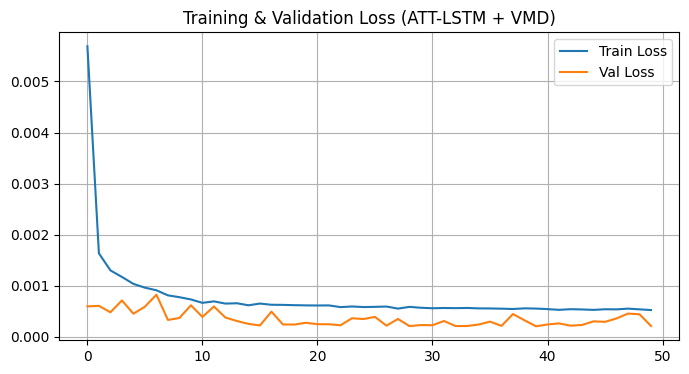

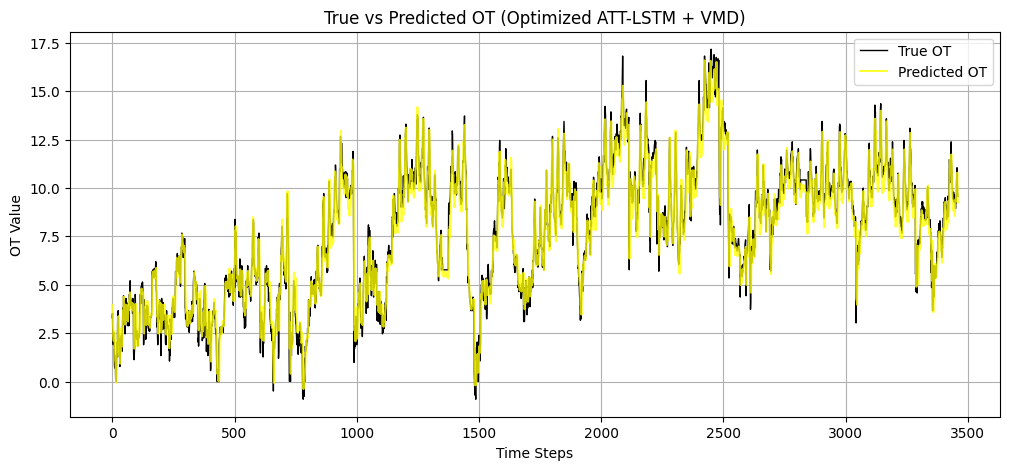

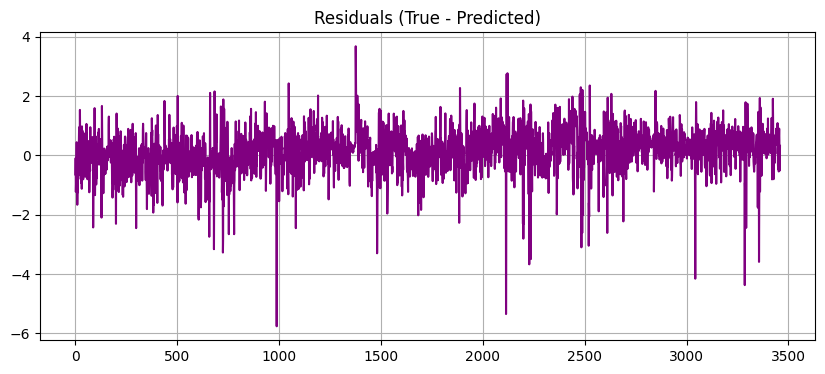

Total Area = 1854.7507745847113
Area + = 1156.108571793885
Area - = -698.6422027908262


In [21]:
model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64,
)
model_build_attlstm_model.summary()

history_attlstm_vmd = model_build_attlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_attlstm_vmd_scaled = model_build_attlstm_model.predict(X_test_vmd_scaled)
y_pred_attlstm_vmd_true = scaler_y.inverse_transform(y_pred_attlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_attlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_attlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_attlstm_vmd_true, label="Predicted OT", color="yellow", alpha=0.8)
plt.title("True vs Predicted OT (Optimized ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_attlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()

res = y_test_vmd_true.squeeze() - y_pred_attlstm_vmd_true.squeeze()
area_total_attlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm_vmd)
area_positive_attlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm_vmd)
print("Area - =", area_negative_attlstm_vmd)

# TAttLSTM+VMD
Temporary Attention + lstm + vmd
📚 Reference for Attention Mechanism

**Bahdanau, Dzmitry; Cho, Kyunghyun; Bengio, Yoshua (2014).**
*Neural Machine Translation by Jointly Learning to Align and Translate.*
arXiv:1409.0473

🔗 [https://arxiv.org/abs/1409.0473](https://arxiv.org/abs/1409.0473)


📚 Reference for VMD (Variational Mode Decomposition)

**Dragomiretskiy, K., & Zosso, D. (2014).**
*Variational Mode Decomposition.*
IEEE Transactions on Signal Processing, 62(3), 531–544.

🔗 [https://doi.org/10.1109/TSP.2013.2288675](https://doi.org/10.1109/TSP.2013.2288675)
🔗 [https://arxiv.org/abs/1406.5858](https://arxiv.org/abs/1406.5858)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 132)        │        75,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 132)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_attention              │ (None, 132)            │        17,689 │
│ (TemporalAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 132)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 132)            │       139,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,690 (944.10 KB)

 Trainable params: 241,690 (944.10 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0055 - mae: 0.0478 - val_loss: 0.0011 - val_mae: 0.0269
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0016 - mae: 0.0301 - val_loss: 4.9358e-04 - val_mae: 0.0159
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0013 - mae: 0.0266 - val_loss: 6.2281e-04 - val_mae: 0.0185
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 4.5958e-04 - val_mae: 0.0169
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 9.4638e-04 - mae: 0.0229 - val_loss: 3.0686e-04 - val_mae: 0.0123
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 8.8765e-04 - mae: 0.0221 - val_loss: 3.3397e-04 - val_mae: 0.0132
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 7.9581e-04 - mae: 0.0209 - val_loss: 3.4264e-04 - val_mae: 0.0133
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 7.4162e-04 - mae: 0.0201 - val_loss: 4.3604e-04 - val_mae: 0.0158
Epoch

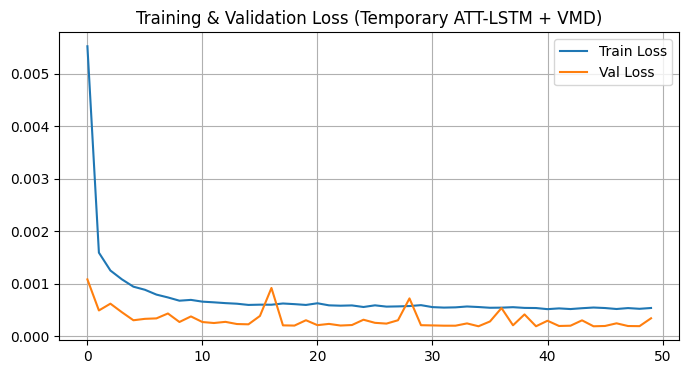

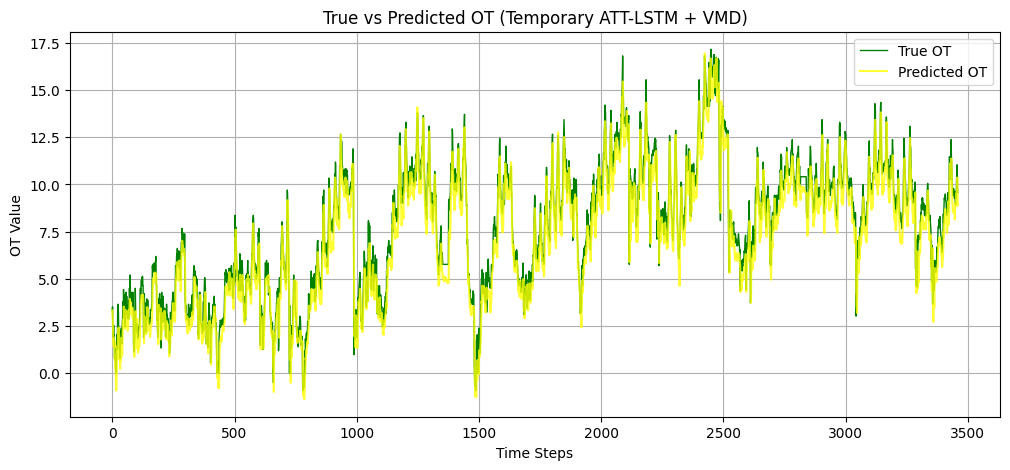

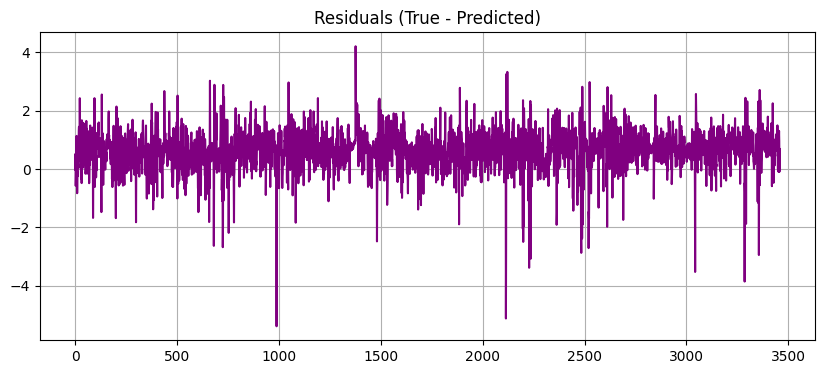

Total Area = 2655.4068773165354
Area + = 2411.7332031503333
Area - = -243.6736741662024


In [22]:
model_build_Tattlstm_model = build_Tattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=132,
    lstm2_units=132,
    dense_units=64,
)
model_build_Tattlstm_model.summary()

history_Tattlstm_vmd = model_build_Tattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_Tattlstm_vmd_scaled = model_build_Tattlstm_model.predict(X_test_vmd_scaled)
y_pred_Tattlstm_vmd_true = scaler_y.inverse_transform(y_pred_Tattlstm_vmd_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_Tattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_Tattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (Temporary ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="green", linewidth=1)
plt.plot(y_pred_Tattlstm_vmd_true, label="Predicted OT", color="yellow", alpha=0.8)
plt.title("True vs Predicted OT (Temporary ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_Tattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()

res = y_test_vmd_true.squeeze() - y_pred_Tattlstm_vmd_true.squeeze()
area_total_Tattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Tattlstm_vmd)
area_positive_Tattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_Tattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Tattlstm_vmd)
print("Area - =", area_negative_Tattlstm_vmd)

# TFT Multi-Head Temporal self-Attention lstm

Model: "TFT_Att_LSTM_Bahdanau"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 24, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_129 (LSTM)                 │ (None, 24, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_171 (Dropout)           │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_309 (Dense)               │ (None, 24, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_95          │ (None, 24, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_87    │ (None, 64)             │         4,224 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_28 (Lambda)              │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_130 (LSTM)                 │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_172 (Dropout)           │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_310 (Dense)               │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_96          │ (None, 1, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_88    │ (None, 64)             │         4,224 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_311 (Dense)               │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_312 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 196,257 (766.63 KB)

 Trainable params: 196,257 (766.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0409 - mae: 0.0938 - val_loss: 0.0012 - val_mae: 0.0276
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0032 - mae: 0.0439 - val_loss: 7.3808e-04 - val_mae: 0.0211
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0024 - mae: 0.0380 - val_loss: 8.0417e-04 - val_mae: 0.0206
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0019 - mae: 0.0335 - val_loss: 5.5231e-04 - val_mae: 0.0170
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0017 - mae: 0.0315 - val_loss: 0.0014 - val_mae: 0.0321
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0016 - mae: 0.0310 - val_loss: 7.3448e-04 - val_mae: 0.0220
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0015 - mae: 0.0298 - val_loss: 6.6016e-04 - val_mae: 0.0188
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0014 - mae: 0.0283 - val_loss: 6.8088e-04 - val_mae: 0.0211
Epoch 9/50
435/435 ━━━━━

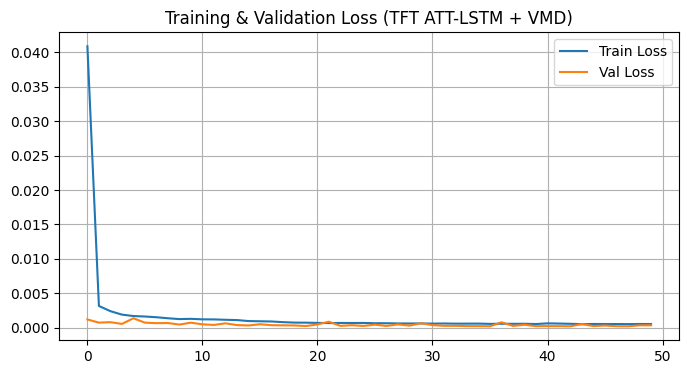

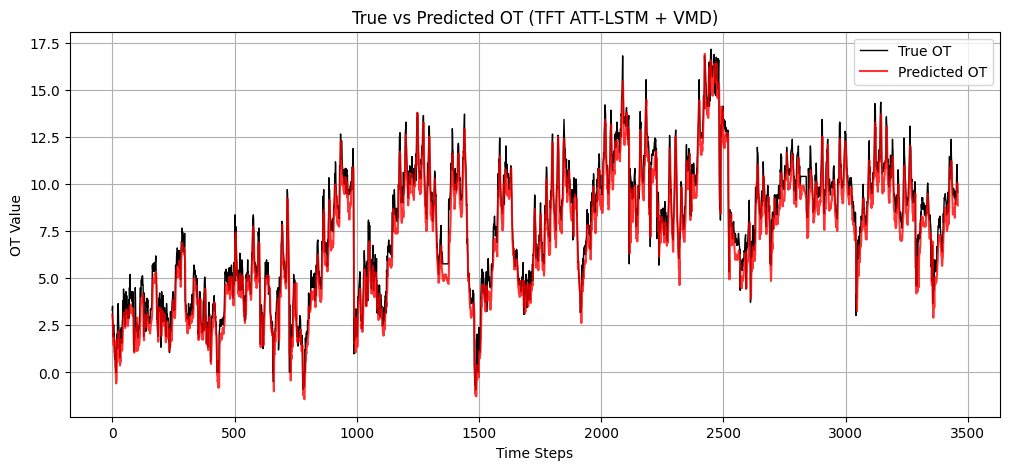

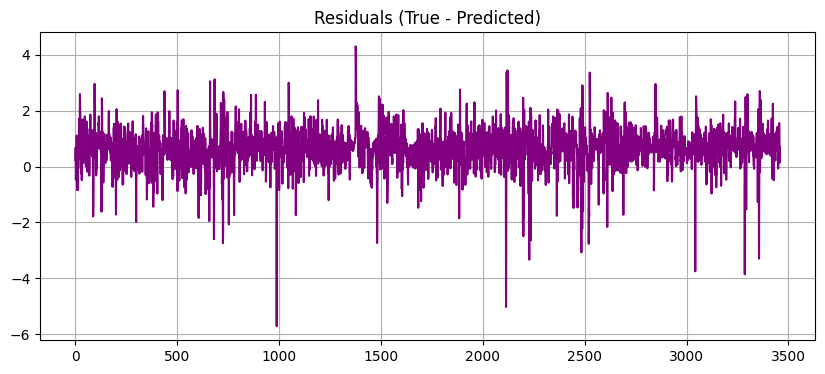

Total Area = 2674.7140728812674
Area + = 2428.33067299612
Area - = -246.38339988514767


In [138]:
model_build_TFTattlstm_model = build_TFTattlstm_model(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=128,
    lstm2_units=128,
    dense_units=16,
    model_dim=64,
    dropout=0.1,
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 24, 128)   │     71,168 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 24, 128)   │     71,168 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 24, 128)   │          0 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 24, 128)   │          0 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 128)       │     16,640 │ dropout_7[0][0]   │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 128)       │     16,640 │ dropout_8[0][0]   │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, 128)    │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 128)    │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     29,056 │ lambda_1[0][0],   │
│ (TFTTemporalAttent… │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 32)        │     10,368 │ tft_temporal_att… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ bidirectional_1[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 215,073 (840.13 KB)

 Trainable params: 215,073 (840.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0043 - mae: 0.0430 - val_loss: 5.5657e-04 - val_mae: 0.0174
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 5.1002e-04 - val_mae: 0.0164
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 6.9498e-04 - val_mae: 0.0216
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0010 - mae: 0.0243 - val_loss: 3.9155e-04 - val_mae: 0.0146
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0011 - mae: 0.0252 - val_loss: 0.0023 - val_mae: 0.0436
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 9.3308e-04 - mae: 0.0230 - val_loss: 3.4959e-04 - val_mae: 0.0135
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 8.0459e-04 - mae: 0.0214 - val_loss: 0.0012 - val_mae: 0.0300
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 7.4056e-04 - mae: 0.0202 - val_loss: 5.0842e-04 - val_mae: 0.0179
Epoch 9/50


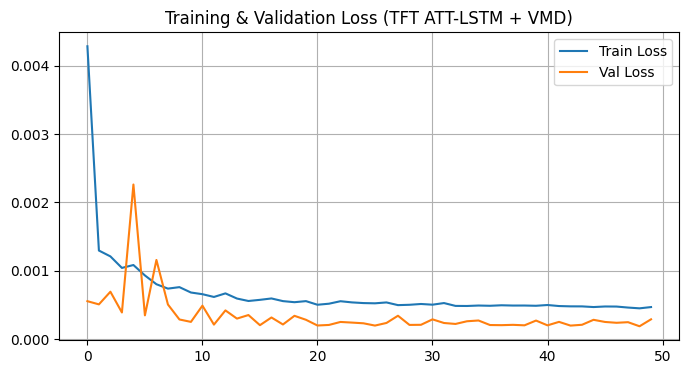

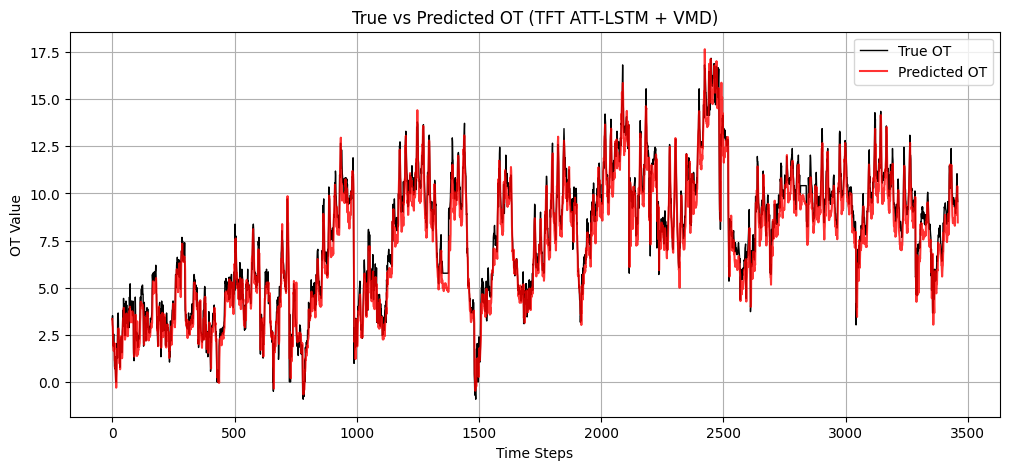

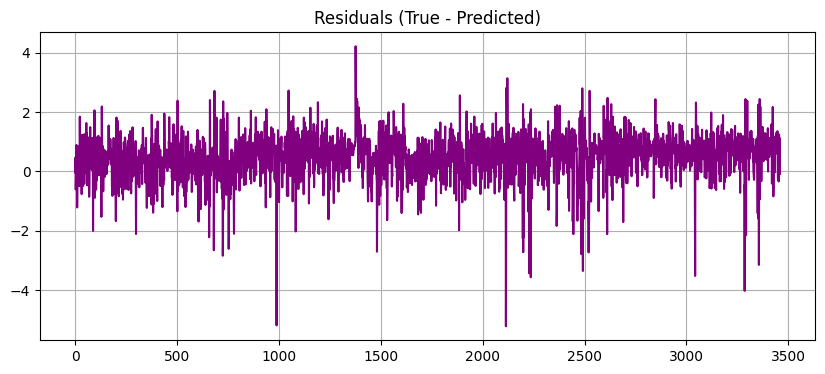

Total Area = 2385.9145785663286
Area + = 2005.2319868933423
Area - = -380.6825916729865


In [24]:
model_build_TFTattlstm_model = build_TFTattlstm_model2(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=128,
    lstm2_units=128,
    dense_units=16,
    num_heads=8,
    model_dim=64,
    dropout=0.1,
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 24, 6)     │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 24, 4)     │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 24, 64)    │     18,176 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 24, 64)    │     17,664 │ lambda_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 24, 64)    │          0 │ lstm_10[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 24, 64)    │          0 │ lstm_11[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_10[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_11[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 256) │    116,224 │ lambda_5[0][0],   │
│ (TFTTemporalAttent… │                   │            │ lambda_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, None, 1)   │        257 │ tft_temporal_att… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 160,769 (628.00 KB)

 Trainable params: 160,769 (628.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.2457 - mae: 0.2317 - val_loss: 0.0073 - val_mae: 0.0679
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0347 - mae: 0.1479 - val_loss: 0.0251 - val_mae: 0.1443
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0352 - mae: 0.1486 - val_loss: 0.0234 - val_mae: 0.1383
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0372 - mae: 0.1526 - val_loss: 0.0526 - val_mae: 0.2190
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0357 - mae: 0.1496 - val_loss: 0.0228 - val_mae: 0.1361
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0355 - mae: 0.1493 - val_loss: 0.0197 - val_mae: 0.1240
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0345 - mae: 0.1471 - val_loss: 0.0050 - val_mae: 0.0604
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0345 - mae: 0.1472 - val_loss: 0.0465 - val_mae: 0.2050
Epoch 9/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - 

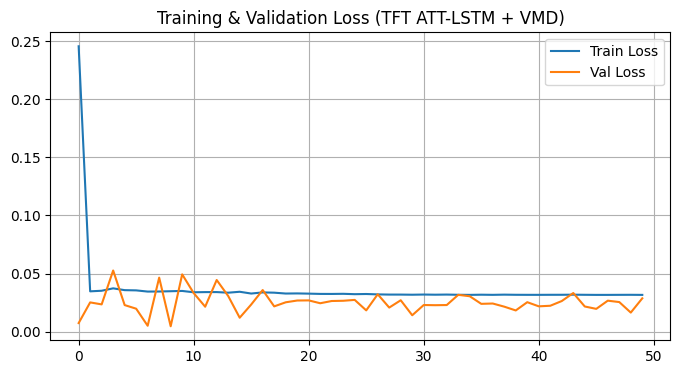

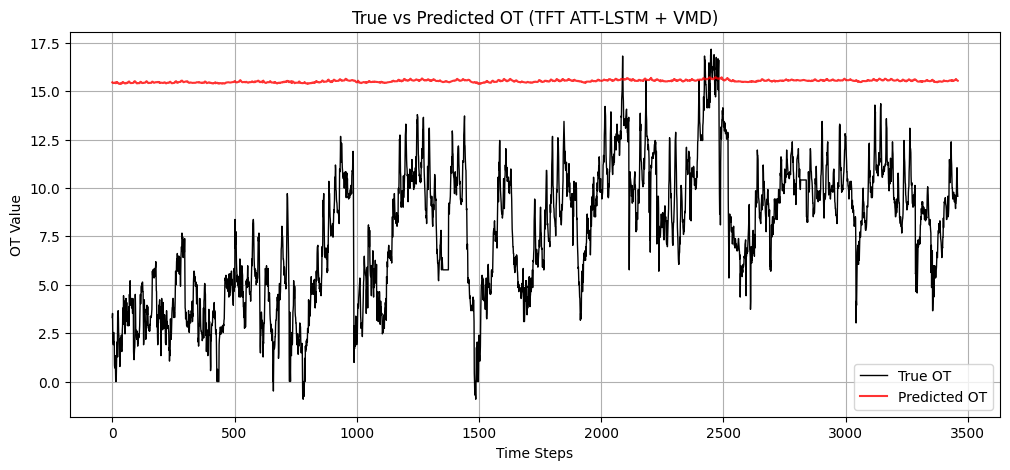

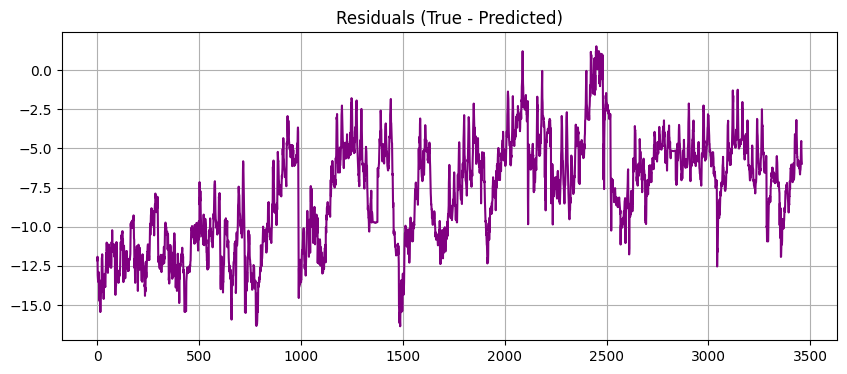

Total Area = 26922.7690423429
Area + = 24.397447586059556
Area - = -26898.37159475684


In [25]:
model_build_TFTattlstm_model = build_TFTattlstm_model3(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=64,
    dense_units=4,
    num_heads=64,
    model_dim=256,
    dropout=0.1,
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 24, 4)     │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 24, 6)     │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 24, 32)    │      4,736 │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 24, 32)    │      4,992 │ lambda_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 24, 32)    │          0 │ lstm_13[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 24, 32)    │          0 │ lstm_12[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 32)        │      1,088 │ dropout_14[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 32)        │      1,088 │ dropout_13[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 1, 32)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 1, 32)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attention     │ (None, 1, 32)     │     67,104 │ lambda_10[0][0],  │
│ (CrossAttention)    │                   │            │ lambda_9[0][0],   │
│                     │                   │            │ lambda_9[0][0],   │
│                     │                   │            │ lambda_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 32)     │          0 │ cross_attention[… │
│ (Concatenate)       │                   │            │ cross_attention[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2, 32)     │     67,104 │ concatenate[0][0… │
│ (MultiHeadAttentio… │                   │            │ concatenate[0][0… │
│                     │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 2, 32)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2, 32)     │         64 │ dropout_17[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 8)         │      1,184 │ layer_normalizat… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │          9 │ bidirectional_2[

 Total params: 147,369 (575.66 KB)

 Trainable params: 147,369 (575.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0100 - mae: 0.0592 - val_loss: 8.7233e-04 - val_mae: 0.0223
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0020 - mae: 0.0338 - val_loss: 6.2463e-04 - val_mae: 0.0184
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0015 - mae: 0.0300 - val_loss: 4.6008e-04 - val_mae: 0.0159
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0013 - mae: 0.0277 - val_loss: 5.2548e-04 - val_mae: 0.0178
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0012 - mae: 0.0266 - val_loss: 4.8593e-04 - val_mae: 0.0169
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0012 - mae: 0.0262 - val_loss: 4.6551e-04 - val_mae: 0.0162
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0012 - mae: 0.0258 - val_loss: 4.6853e-04 - val_mae: 0.0163
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0012 - mae: 0.0257 - val_loss: 4.5759e-04 - val_mae: 0.0154
Epoch 9/50
435/

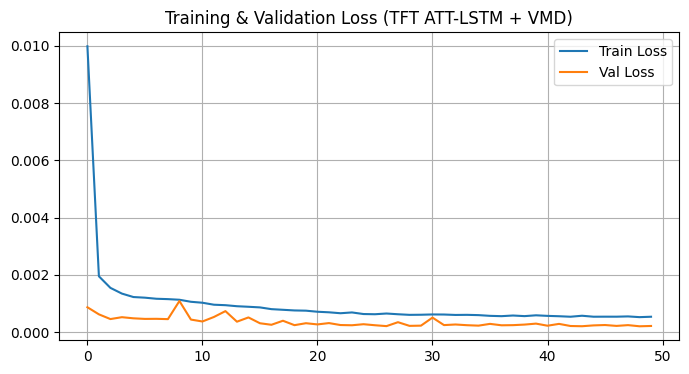

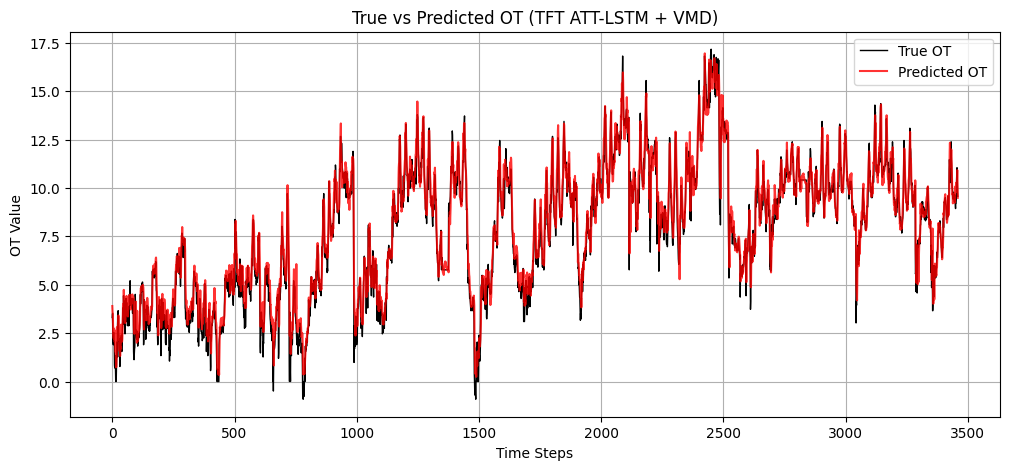

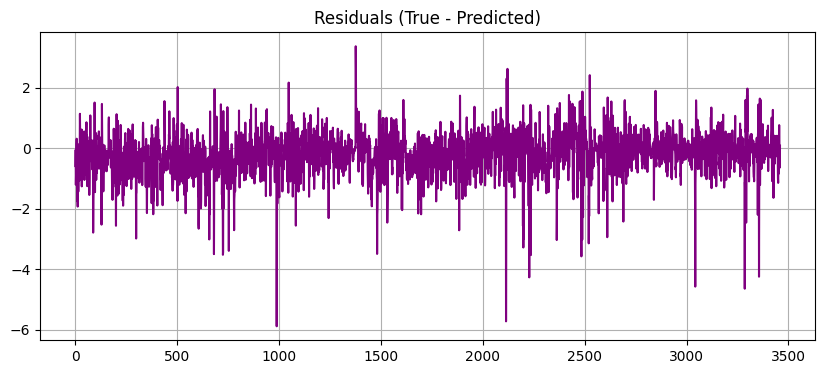

Total Area = 1828.0383834540842
Area + = 531.3217680752284
Area - = -1296.7166153788557


In [26]:
model_build_TFTattlstm_model = build_TFTattlstm_model4(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=32,
    dense_units=4,
    num_heads=8,
    model_dim=64,
    dropout=0.1,
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 24, 6)     │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 24, 4)     │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 24, 64)    │     18,176 │ lambda_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 24, 64)    │     17,664 │ lambda_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 24, 64)    │          0 │ lstm_15[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 24, 64)    │          0 │ lstm_16[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_18[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ dropout_19[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2, 64)     │          0 │ lambda_13[0][0],  │
│ (Concatenate)       │                   │            │ lambda_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 16)        │      2,064 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 16)        │      2,064 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kl_divergence_layer │ [(None, 16),      │          0 │ dense_24[0][0],   │
│ (KLDivergenceLayer) │ (None, 16)]       │            │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 16)        │          0 │ kl_divergence_la… │
│                     │                   │            │ kl_divergence_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 64)        │      1,088 │ sampling[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │      8,320 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 2, 64)     │          0 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 256) │    116,224 │ reshape_2[0][0],

 Total params: 191,025 (746.19 KB)

 Trainable params: 191,025 (746.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0361 - mae: 0.1465 - val_loss: 0.0257 - val_mae: 0.1452
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0316 - mae: 0.1410 - val_loss: 0.0223 - val_mae: 0.1335
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0316 - mae: 0.1408 - val_loss: 0.0259 - val_mae: 0.1462
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0316 - mae: 0.1409 - val_loss: 0.0218 - val_mae: 0.1318
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0316 - mae: 0.1409 - val_loss: 0.0255 - val_mae: 0.1447
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0316 - mae: 0.1410 - val_loss: 0.0222 - val_mae: 0.1334
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0315 - mae: 0.1409 - val_loss: 0.0240 - val_mae: 0.1395
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0316 - mae: 0.1410 - val_loss: 0.0223 - val_mae: 0.1337
Epoch 9/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms

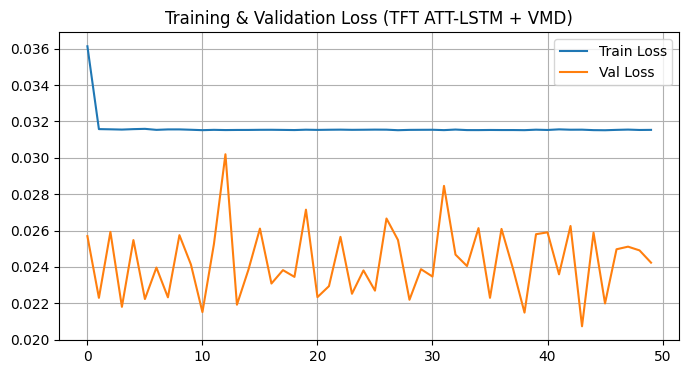

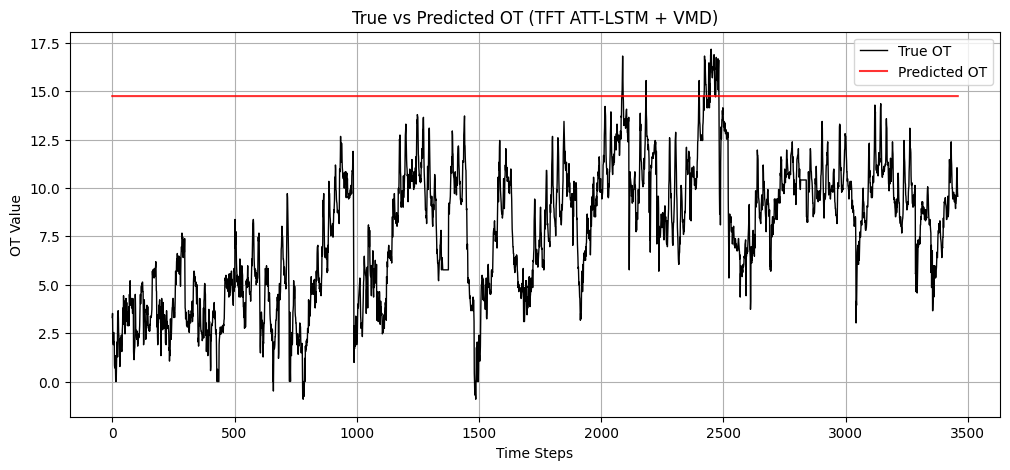

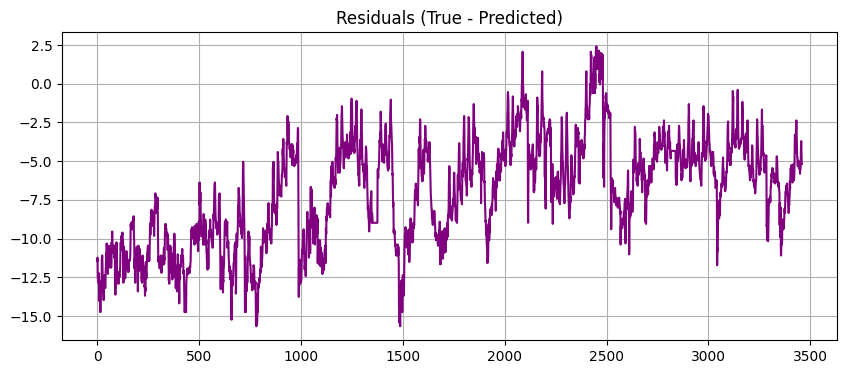

Total Area = 24332.100690215826
Area + = 67.20616626739502
Area - = -24264.89452394843


In [27]:
model_build_TFTattlstm_model = build_TFTattlstm_model5(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=64,
    dense_units=8,
    num_heads=8,
    model_dim=256,
    dropout=0.1,
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, 24, 6)     │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_16 (Lambda)  │ (None, 24, 4)     │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 24, 64)    │     18,176 │ lambda_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 24, 64)    │     17,664 │ lambda_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 24, 64)    │          0 │ lstm_18[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 24, 64)    │          0 │ lstm_19[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attention │ (None, 24, 64)    │     16,644 │ dropout_21[0][0], │
│ (PerformerAttentio… │                   │            │ dropout_21[0][0], │
│                     │                   │            │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attentio… │ (None, 24, 64)    │     16,644 │ dropout_22[0][0], │
│ (PerformerAttentio… │                   │            │ dropout_22[0][0], │
│                     │                   │            │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_last_step    │ (None, 64)        │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group2_last_step    │ (None, 64)        │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128)       │          0 │ group1_last_step… │
│ (Concatenate)       │                   │            │ group2_last_step… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 8)         │      1,032 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 1)         │          9 │ dense_41[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,169 (274.10 KB)

 Trainable params: 70,161 (274.07 KB)

 Non-trainable params: 8 (32.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0029 - mae: 0.0376 - val_loss: 5.2250e-04 - val_mae: 0.0169
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0012 - mae: 0.0258 - val_loss: 4.5744e-04 - val_mae: 0.0169
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 8.5043e-04 - mae: 0.0217 - val_loss: 2.8718e-04 - val_mae: 0.0122
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 7.6407e-04 - mae: 0.0206 - val_loss: 2.6278e-04 - val_mae: 0.0116
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 6.8739e-04 - mae: 0.0194 - val_loss: 2.6044e-04 - val_mae: 0.0117
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 6.5559e-04 - mae: 0.0188 - val_loss: 2.7089e-04 - val_mae: 0.0124
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 6.1741e-04 - mae: 0.0183 - val_loss: 2.3458e-04 - val_mae: 0.0110
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 6.1930e-04 - mae: 0.0184 - val_loss: 2.2534e-04 - val_mae:

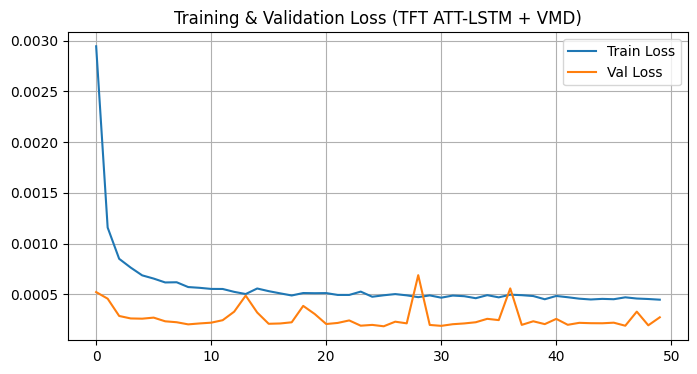

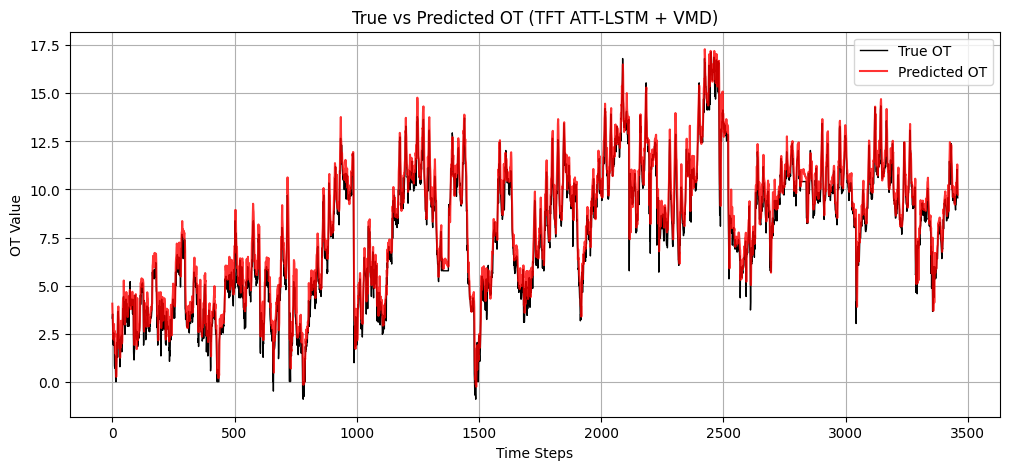

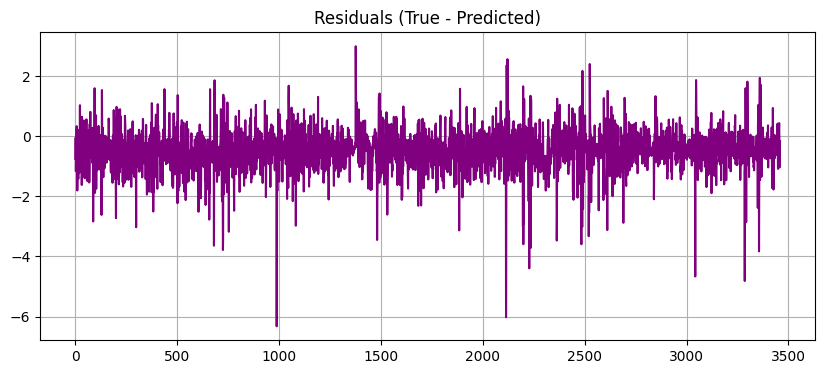

Total Area = 2153.6407188475123
Area + = 260.17152298241876
Area - = -1893.4691958650935


In [28]:
model_build_TFTattlstm_model = build_TFTattlstm_model6(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=64,
    dense_units=8,
    num_heads=32,
    model_dim=64,
    dropout=0.1,
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_24 (LSTM)      │ (None, 24, 84)    │     31,920 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 24, 84)    │          0 │ lstm_24[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ (None, 24, 84)    │     31,920 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 84)        │      7,224 │ dropout_31[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 24, 84)    │          0 │ lstm_25[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_bahdanau_ex… │ (None, 1, 84)     │          0 │ attention_layer_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attentio… │ (None, 24, 128)   │     49,168 │ dropout_32[0][0], │
│ (PerformerAttentio… │                   │            │ dropout_32[0][0], │
│                     │                   │            │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_last_step    │ (None, 84)        │          0 │ group1_bahdanau_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group2_last_step    │ (None, 128)       │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 212)       │          0 │ group1_last_step… │
│ (Concatenate)       │                   │            │ group2_last_step… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 32)        │      6,816 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 1)         │         33 │ dense_59[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 127,081 (496.41 KB)

 Trainable params: 127,065 (496.35 KB)

 Non-trainable params: 16 (64.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0396 - mse: 0.0034 - val_loss: 0.0277 - val_mse: 0.0011
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0302 - mse: 0.0016 - val_loss: 0.0222 - val_mse: 7.5971e-04
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0246 - mse: 0.0011 - val_loss: 0.0206 - val_mse: 7.1768e-04
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0250 - mse: 0.0011 - val_loss: 0.0225 - val_mse: 7.2010e-04
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0221 - mse: 8.8059e-04 - val_loss: 0.0144 - val_mse: 3.8136e-04
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0202 - mse: 7.3735e-04 - val_loss: 0.0138 - val_mse: 3.5907e-04
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0197 - mse: 7.0117e-04 - val_loss: 0.0124 - val_mse: 2.7561e-04
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0190 - mse: 6.5719e-04 - val_loss: 0.0110 - val_mse: 2.4229e-04
Epoc

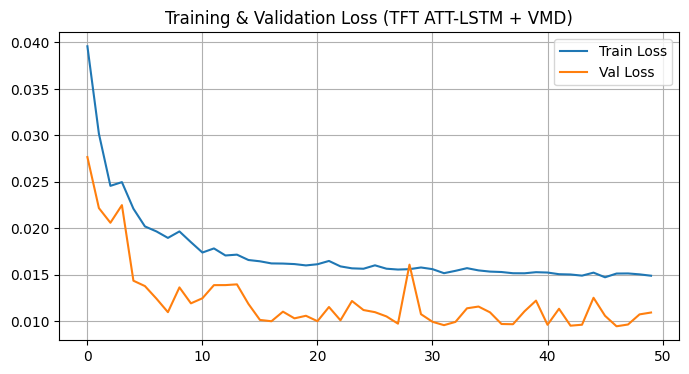

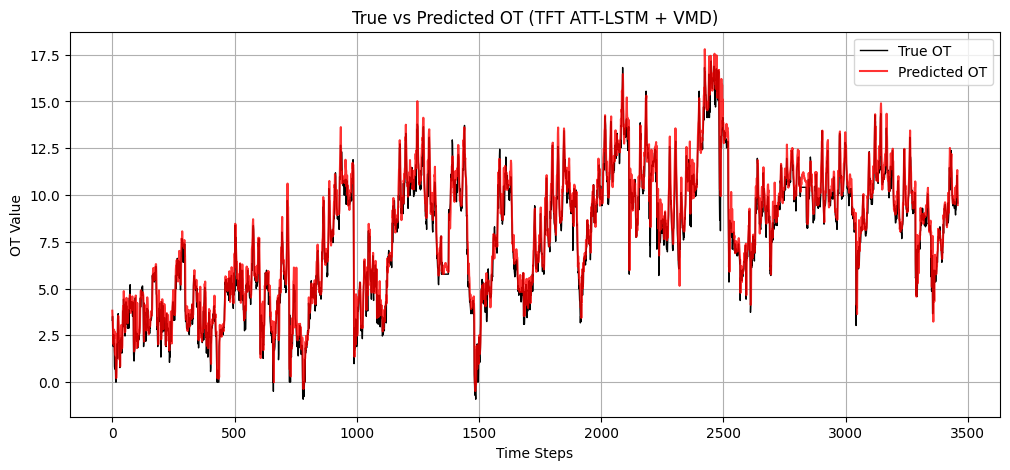

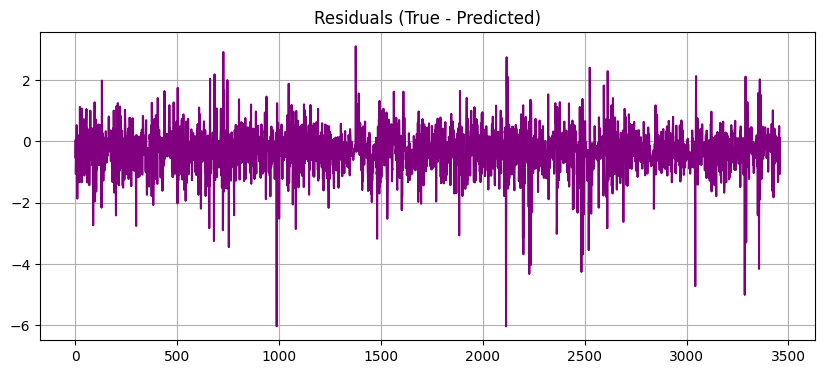

Total Area = 1897.7765941170214
Area + = 408.86628804728434
Area - = -1488.910306069737


In [31]:
model_build_TFTattlstm_model = build_TFTattlstm_model7(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=84,
    dense_units=32,
    num_heads=32,
    model_dim=128,
    dropout=0.1,
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_38 (LSTM)      │ (None, 24, 84)    │     31,920 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 24, 84)    │          0 │ lstm_38[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_39 (LSTM)      │ (None, 24, 84)    │     31,920 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 24, 64)    │     64,576 │ dropout_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 24, 84)    │          0 │ lstm_39[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 24, 64)    │     64,576 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ batch_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 64)    │        256 │ conv1d_29[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_bahdanau_ex… │ (None, 1, 64)     │          0 │ attention_layer_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attentio… │ (None, 24, 64)    │     16,644 │ batch_normalizat… │
│ (PerformerAttentio… │                   │            │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_last_step    │ (None, 64)        │          0 │ group1_bahdanau_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group2_last_step    │ (None, 64)        │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 128)       │          0 │ group1_last_step… │
│ (Concatenate)       │                   │            │ group2_last_step… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_92 (Dense)    │ (None, 128)       │     16,512 │ concatenate_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_93 (Dense)    │ (None, 1)         │        129 │ dense_92[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 231,013 (902.39 KB)

 Trainable params: 230,753 (901.38 KB)

 Non-trainable params: 260 (1.02 KB)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0609 - mse: 0.0074 - val_loss: 0.0515 - val_mse: 0.0033
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0412 - mse: 0.0028 - val_loss: 0.0196 - val_mse: 6.4517e-04
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0390 - mse: 0.0025 - val_loss: 0.0645 - val_mse: 0.0046
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0375 - mse: 0.0023 - val_loss: 0.0456 - val_mse: 0.0027
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0349 - mse: 0.0020 - val_loss: 0.0620 - val_mse: 0.0045
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0326 - mse: 0.0018 - val_loss: 0.0217 - val_mse: 7.0366e-04
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0318 - mse: 0.0017 - val_loss: 0.0981 - val_mse: 0.0100
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0331 - mse: 0.0018 - val_loss: 0.0159 - val_mse: 4.1664e-04
Epoch 9/50
435/435 ━━━━━━━━━━━━━━━━━

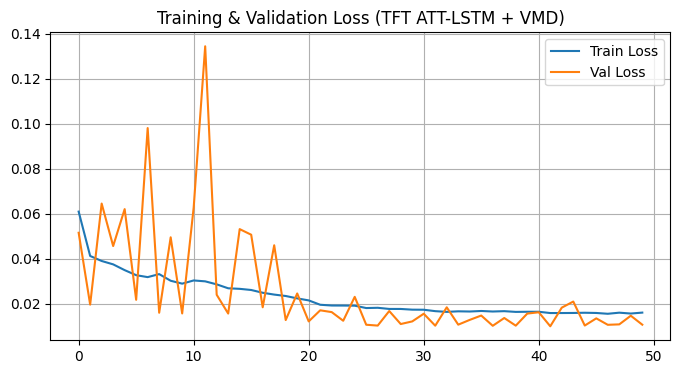

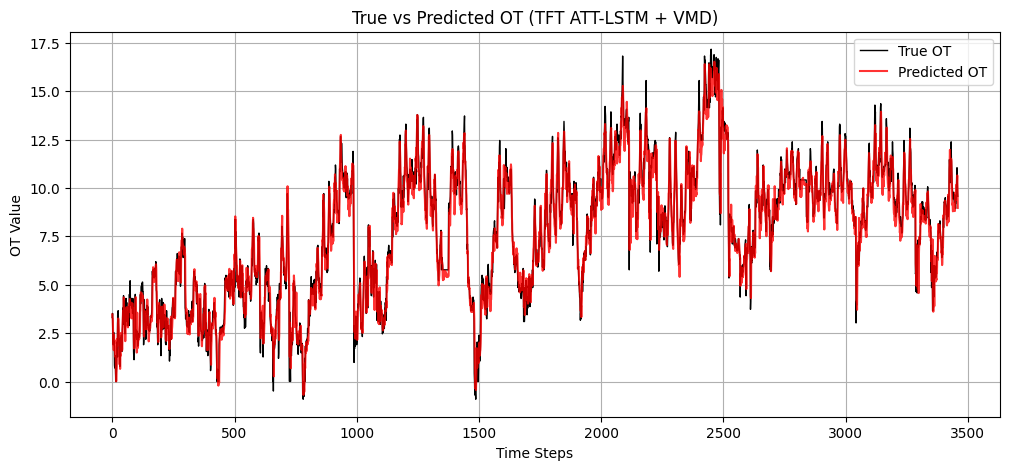

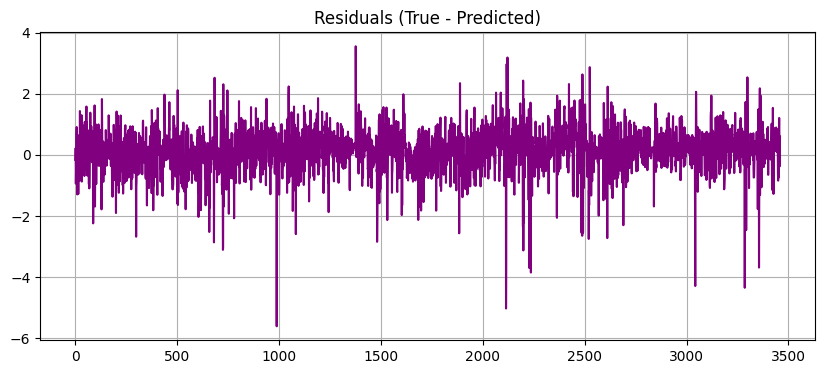

Total Area = 1840.044509752654
Area + = 1135.2853209562609
Area - = -704.7591887963931


In [41]:
model_build_TFTattlstm_model = build_TFTattlstm_model8(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=84,
    cnn_filters=64,
    cnn_kernel=12,
    dense_units=128,
    num_heads=32,
    model_dim=64,
    dropout=0.1,
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_36 (LSTM)      │ (None, 24, 84)    │     31,920 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ (None, 24, 84)    │     31,920 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 24, 84)    │          0 │ lstm_36[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_45          │ (None, 24, 84)    │          0 │ lstm_37[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 84)        │      7,224 │ dropout_44[0][0]  │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group2_cnn (Conv1D) │ (None, 24, 64)    │     64,576 │ dropout_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_bahdanau_ex… │ (None, 1, 84)     │          0 │ attention_layer_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ performer_attentio… │ (None, 24, 128)   │     41,488 │ group2_cnn[0][0], │
│ (PerformerAttentio… │                   │            │ group2_cnn[0][0], │
│                     │                   │            │ group2_cnn[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group1_last_step    │ (None, 84)        │          0 │ group1_bahdanau_… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group2_last_step    │ (None, 128)       │          0 │ performer_attent… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 212)       │          0 │ group1_last_step… │
│ (Concatenate)       │                   │            │ group2_last_step… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_86 (Dense)    │ (None, 128)       │     27,264 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_87 (Dense)    │ (None, 1)         │        129 │ dense_86[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 204,521 (798.91 KB)

 Trainable params: 204,505 (798.85 KB)

 Non-trainable params: 16 (64.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0382 - mse: 0.0037 - val_loss: 0.0154 - val_mse: 4.7078e-04
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0254 - mse: 0.0012 - val_loss: 0.0149 - val_mse: 4.3574e-04
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0234 - mse: 9.8054e-04 - val_loss: 0.0136 - val_mse: 3.4698e-04
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0214 - mse: 8.2938e-04 - val_loss: 0.0139 - val_mse: 3.5734e-04
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0207 - mse: 7.8009e-04 - val_loss: 0.0139 - val_mse: 3.2979e-04
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0198 - mse: 7.1453e-04 - val_loss: 0.0331 - val_mse: 0.0013
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0191 - mse: 6.6665e-04 - val_loss: 0.0132 - val_mse: 3.1833e-04
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0192 - mse: 6.7546e-04 - val_loss: 0.0209 - val_mse: 6.6658e

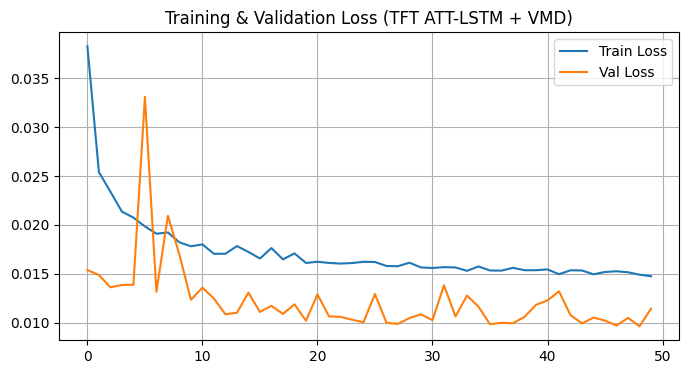

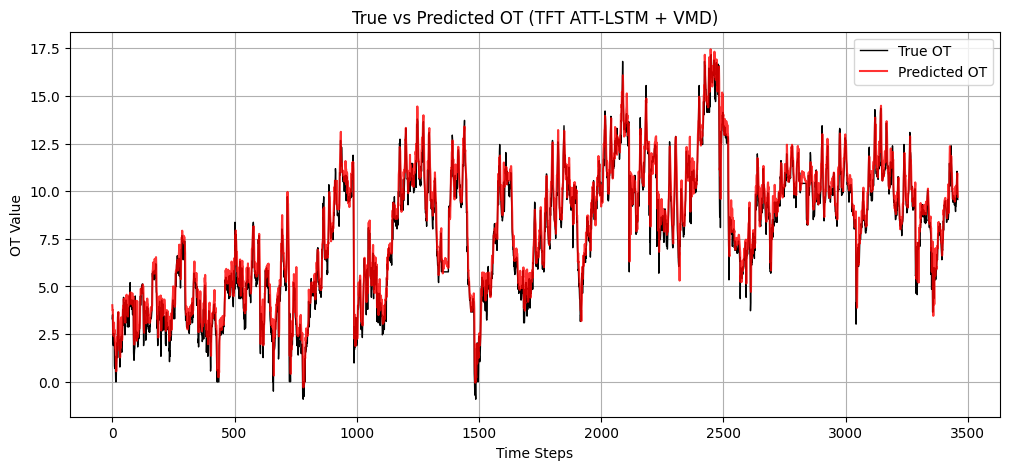

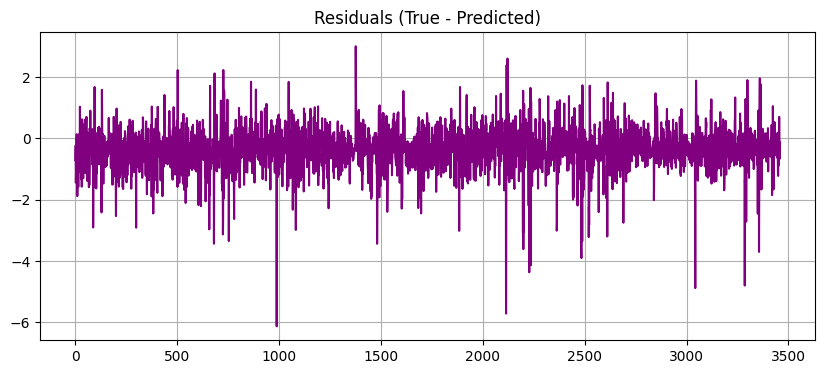

Total Area = 1982.9204813055687
Area + = 362.5039063952867
Area - = -1620.4165749102822


In [40]:
model_build_TFTattlstm_model = build_TFTattlstm_model9(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=84,
    cnn_filters=64,
    cnn_kernel=12,
    dense_units=128,
    num_heads=32,
    model_dim=128,
    dropout=0.2,
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_82 (LSTM)      │ (None, 24, 32)    │      5,504 │ input_layer_33[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_92          │ (None, 24, 32)    │          0 │ lstm_82[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_cnn         │ (None, 24, 128)   │     49,280 │ dropout_92[0][0]  │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_173 (Dense)   │ (None, 24, 64)    │      8,256 │ encoder_cnn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dense_173[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_expand (Lambda) │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_83 (LSTM)      │ (None, 1, 32)     │     12,416 │ enc_expand[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_93          │ (None, 1, 32)     │          0 │ lstm_83[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_cnn         │ (None, 1, 128)    │     49,280 │ dropout_93[0][0]  │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_174 (Dense)   │ (None, 1, 64)     │      8,256 │ decoder_cnn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ dense_174[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tft_temporal_atten… │ (None, None, 64)  │     16,768 │ enc_expand[0][0], │
│ (TFTTemporalAttent… │                   │            │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_19    │ (None, 24)        │      7,392 │ tft_temporal_att… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_179 (Dense)   │ (None, 1)         │         25 │ bidirectional_19… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 165,881 (647.97 KB)

 Trainable params: 165,881 (647.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0411 - mse: 0.0051 - val_loss: 0.0318 - val_mse: 0.0013
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0267 - mse: 0.0013 - val_loss: 0.0138 - val_mse: 3.7566e-04
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0237 - mse: 0.0010 - val_loss: 0.0287 - val_mse: 0.0012
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0230 - mse: 9.4225e-04 - val_loss: 0.0133 - val_mse: 3.4130e-04
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0222 - mse: 8.8562e-04 - val_loss: 0.0136 - val_mse: 3.5787e-04
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0218 - mse: 8.4990e-04 - val_loss: 0.0141 - val_mse: 3.7936e-04
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0198 - mse: 7.2166e-04 - val_loss: 0.0144 - val_mse: 3.8507e-04
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0201 - mse: 7.3391e-04 - val_loss: 0.0139 - val_mse: 3.5659e-04
Epo

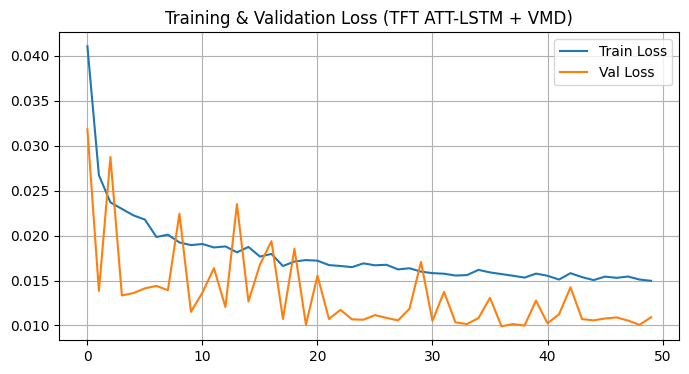

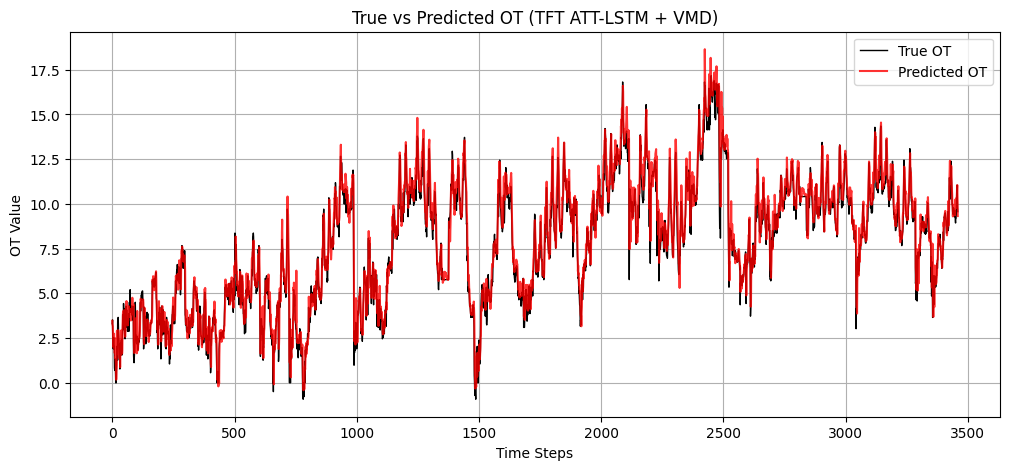

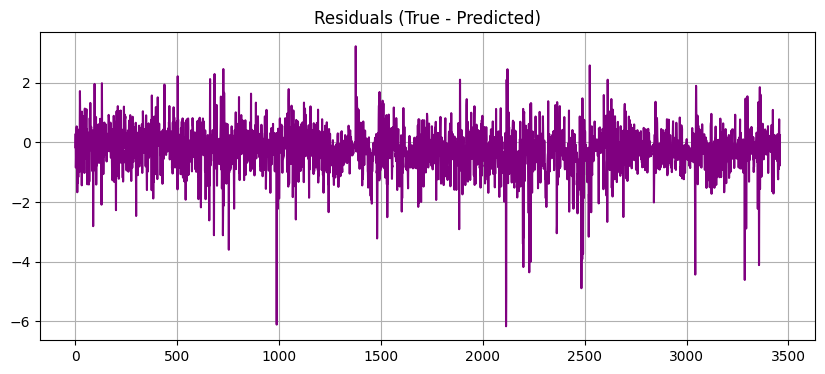

Total Area = 1891.724076050566
Area + = 489.8619429499381
Area - = -1401.862133100628


In [80]:
(
    model_build_TFTattlstm_model,
    encoder_inputs,
    enc_out,
    bahdanau_att_enc,
    dec_out,
    bahdanau_att_dec,
    att_out,
) = build_TFTattlstm_model10(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=32,
    cnn_filters=128,
    cnn_kernel=12,
    dense_units=12,
    num_heads=32,
    model_dim=64,
    dropout=0.1,
)


model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

print(f"encoder_inputs:{encoder_inputs.shape}")
print(f"enc_out:{enc_out.shape}")
print(f"bahdanau_att_enc:{bahdanau_att_enc.shape}")
print(f"dec_out:{dec_out.shape}")
print(f"att_out:{att_out.shape}")

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34      │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_85 (LSTM)      │ (None, 24, 84)    │     31,920 │ input_layer_34[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_95          │ (None, 24, 84)    │          0 │ lstm_85[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 24, 32)    │      2,720 │ dropout_95[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 24, 32)    │          0 │ conv1d_30[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 24, 64)    │      6,208 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 24, 64)    │     10,304 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 24, 64)    │     14,400 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 24, 64)    │      2,112 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 24, 256)   │          0 │ conv1d_31[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_32[0][0],  │
│                     │                   │            │ conv1d_33[0][0],  │
│                     │                   │            │ conv1d_34[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 256)   │      1,024 │ concatenate_13[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 24, 256)   │     21,760 │ dropout_95[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 24, 256)   │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 24, 256)   │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_180 (Dense)   │ (None, 24, 64)    │     16,448 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dense_180[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_19 (Lambda)  │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_86 (LSTM)      │ (None, 1, 84)     │     50,064 │ lambda_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 282,305 (1.08 MB)

 Trainable params: 281,281 (1.07 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.0511 - mse: 0.0047 - val_loss: 0.0499 - val_mse: 0.0031
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0369 - mse: 0.0023 - val_loss: 0.0215 - val_mse: 7.2925e-04
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0373 - mse: 0.0023 - val_loss: 0.0224 - val_mse: 9.1142e-04
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0350 - mse: 0.0020 - val_loss: 0.0202 - val_mse: 6.4544e-04
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0305 - mse: 0.0016 - val_loss: 0.0782 - val_mse: 0.0067
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 0.0291 - mse: 0.0014 - val_loss: 0.0184 - val_mse: 5.5514e-04
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0273 - mse: 0.0013 - val_loss: 0.0456 - val_mse: 0.0024
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0260 - mse: 0.0012 - val_loss: 0.0363 - val_mse: 0.0018
Epoch 9/50
435/435 ━━━━━━━━━

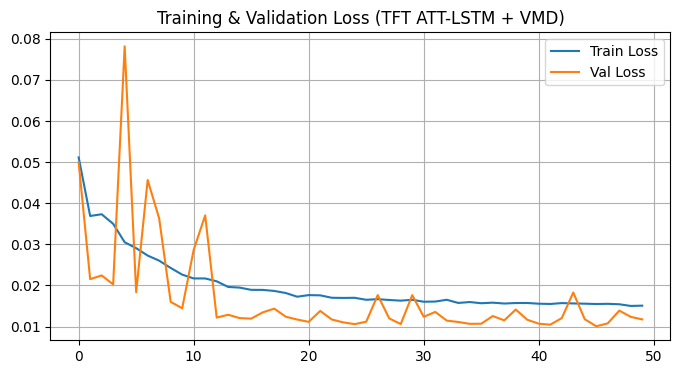

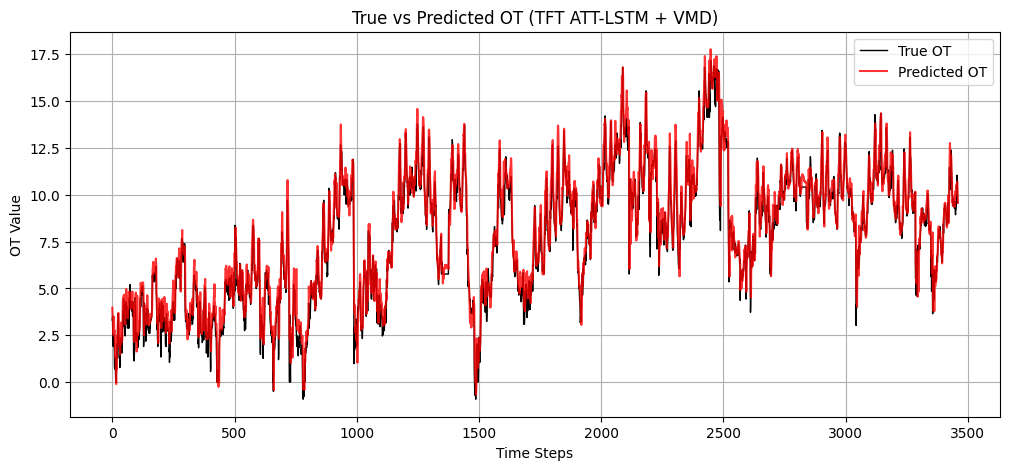

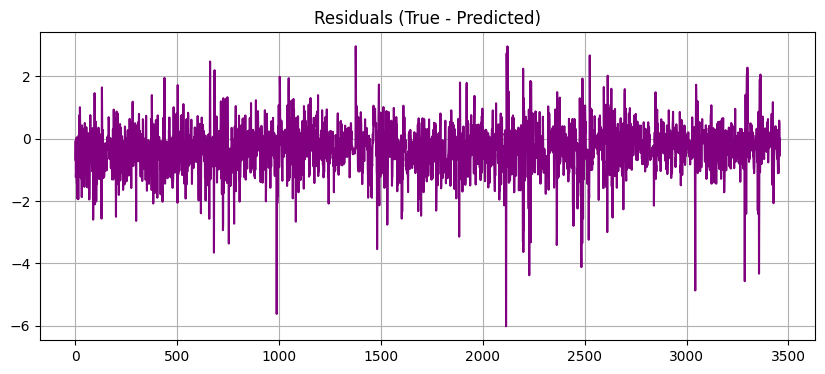

Total Area = 2032.3019599858667
Area + = 456.5388258006428
Area - = -1575.7631341852239


In [88]:
model_build_TFTattlstm_model = build_TFTattlstm_model11(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=84,
    cnn_filters=64,
    dense_units=32,
    num_heads=32,
    model_dim=64,
    dropout=0.1,
    feature_extractor="inception",
)

model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

Model: "TFT_Att_LSTM_Conv_Bahdanau"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_73      │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_177 (LSTM)     │ (None, 24, 80)    │     29,120 │ input_layer_73[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_224         │ (None, 24, 80)    │          0 │ lstm_177[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 80)    │        160 │ dropout_224[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_75 (Conv1D)  │ (None, 24, 8)     │     81,928 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_383 (Dense)   │ (None, 24, 64)    │        576 │ conv1d_75[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dense_383[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_178 (LSTM)     │ (None, 24, 64)    │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_179 (LSTM)     │ (None, 24, 80)    │     29,120 │ input_layer_73[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_225         │ (None, 24, 64)    │          0 │ lstm_178[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_226         │ (None, 24, 80)    │          0 │ lstm_179[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dropout_225[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 80)    │        160 │ dropout_226[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 24, 8)     │     65,544 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 24, 8)     │     81,928 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_384 (Dense)   │ (None, 24, 64)    │        576 │ conv1d_76[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_385 (Dense)   │ (None, 24, 64)    │        576 │ conv1d_77[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dense_384[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dense_385[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat

 Total params: 342,105 (1.31 MB)

 Trainable params: 342,105 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0618 - mse: 0.0214 - val_loss: 0.0243 - val_mse: 8.6660e-04
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0358 - mse: 0.0021 - val_loss: 0.0252 - val_mse: 9.1331e-04
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0354 - mse: 0.0021 - val_loss: 0.0229 - val_mse: 7.7028e-04
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0345 - mse: 0.0019 - val_loss: 0.0172 - val_mse: 4.6807e-04
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0285 - mse: 0.0014 - val_loss: 0.0266 - val_mse: 9.2598e-04
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0287 - mse: 0.0014 - val_loss: 0.0388 - val_mse: 0.0018
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0268 - mse: 0.0012 - val_loss: 0.0133 - val_mse: 3.1695e-04
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0239 - mse: 9.6408e-04 - val_loss: 0.0157 - val_mse: 4.0965e-04
Epoch 9/50
435/

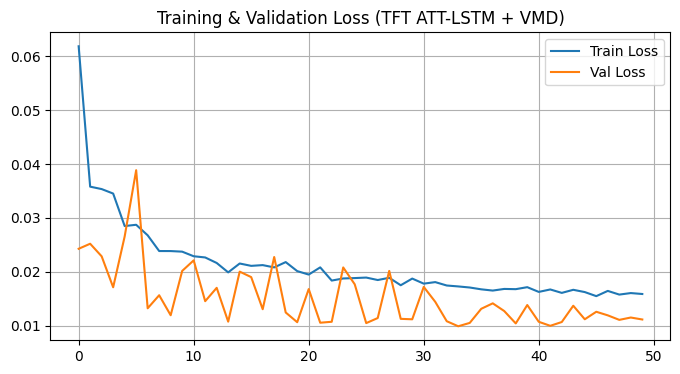

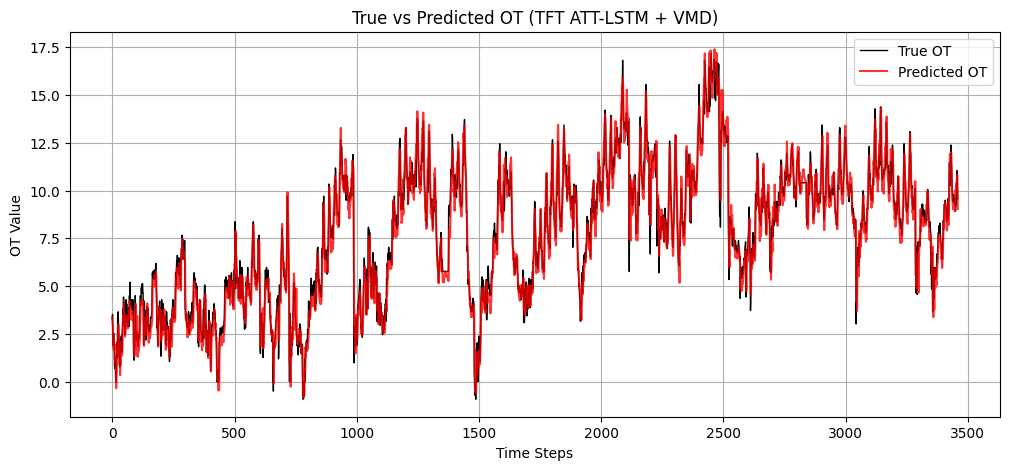

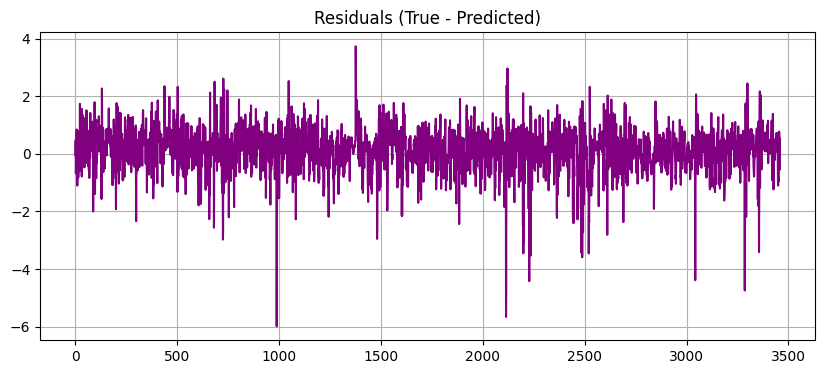

Total Area = 1937.057055724785
Area + = 1188.0955429151663
Area - = -748.9615128096187
encoder_inputs:(None, 24, 10)
enc_out:(None, 24, 64)
dec_out:(None, 24, 64)
att_out:(None, 1, 64)


In [181]:
(
    model_build_TFTattlstm_model,
    encoder_inputs,
    enc_out,
    dec_out,
    att_out,
) = build_TFTattlstm_model12(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=80,
    cnn_filters=8,
    cnn_kernel=128,
    dense_units=32,
    model_dim=64,
    dropout=0.1,
)


model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)

print(f"encoder_inputs:{encoder_inputs.shape}")
print(f"enc_out:{enc_out.shape}")
print(f"dec_out:{dec_out.shape}")
print(f"att_out:{att_out.shape}")

In [ ]:
(   model_build_TFTattlstm_model,
    grad2,
    block1,
    block2,
    att_out,
) = build_TFTattlstm_model13(
    input_shape=(SEQ_LEN, X_train_vmd_scaled.shape[2]),
    lstm1_units=40,
    cnn_filters=44,
    cnn_kernel=16,
    dense_units=16,
    model_dim=64,
    dropout=0.2,
)


model_build_TFTattlstm_model.summary()

history_TFTattlstm_vmd = model_build_TFTattlstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict and inverse-transform
y_pred_TFTattlstm_vmd_scaled = model_build_TFTattlstm_model.predict(X_test_vmd_scaled)
# Flatten to 2D: (num_samples*time_steps, 1)
y_pred_flat = y_pred_TFTattlstm_vmd_scaled.reshape(-1, 1)
# Inverse transform
y_pred_TFTattlstm_vmd_true = scaler_y.inverse_transform(y_pred_flat)

# Optional: reshape back to (num_samples, time_steps)
y_pred_TFTattlstm_vmd_true = y_pred_TFTattlstm_vmd_true.reshape(
    y_pred_TFTattlstm_vmd_scaled.shape[0], y_pred_TFTattlstm_vmd_scaled.shape[1]
)
# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_TFTattlstm_vmd.history["loss"], label="Train Loss")
plt.plot(history_TFTattlstm_vmd.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (TFT ATT-LSTM + VMD)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_TFTattlstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (TFT ATT-LSTM + VMD)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()


res = y_test_vmd_true.squeeze() - y_pred_TFTattlstm_vmd_true.squeeze()
area_total_TFTattlstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_TFTattlstm_vmd)
area_positive_TFTattlstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_TFTattlstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_TFTattlstm_vmd)
print("Area - =", area_negative_TFTattlstm_vmd)


Model: "TFT_Att_LSTM_Conv"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ model_input         │ (None, 24, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_20 (LSTM)      │ (None, 24, 40)    │      8,160 │ model_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_96          │ (None, 24, 40)    │          0 │ lstm_20[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_125 (Dense)   │ (None, 24, 64)    │      2,624 │ dropout_96[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dense_125[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer__b… │ (None, 64)        │      4,224 │ layer_normalizat… │
│ (AttentionLayer_Ba… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 1, 64)     │          0 │ attention_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rowwise_division_1  │ (None, 24, 10)    │          0 │ model_input[0][0] │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_21 (LSTM)      │ (None, 1, 64)     │     33,024 │ lambda_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rowwise_division_2  │ (None, 24, 10)    │          0 │ rowwise_division… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_97          │ (None, 1, 64)     │          0 │ lstm_21[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_block1 (LSTM)  │ (None, 24, 40)    │      8,160 │ rowwise_division… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_block2 (LSTM)  │ (None, 24, 64)    │     19,200 │ rowwise_division… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_126 (Dense)   │ (None, 1, 64)     │      4,160 │ dropout_97[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_94          │ (None, 24, 40)    │          0 │ lstm_block1[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_95          │ (None, 24, 64)    │          0 │ lstm_block2[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ dense_126[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 40)    │         80 │ dropout_94[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 64)    │        128 │ dropout_95[0][0]  │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 185,033 (722.79 KB)

 Trainable params: 185,033 (722.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.1006 - mse: 0.0829 - val_loss: 0.0253 - val_mse: 0.0010
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0422 - mse: 0.0030 - val_loss: 0.0924 - val_mse: 0.0092
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0381 - mse: 0.0025 - val_loss: 0.0213 - val_mse: 7.2276e-04
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0337 - mse: 0.0020 - val_loss: 0.0264 - val_mse: 9.7610e-04
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0323 - mse: 0.0018 - val_loss: 0.0212 - val_mse: 7.9827e-04
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0310 - mse: 0.0017 - val_loss: 0.0264 - val_mse: 0.0011
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0307 - mse: 0.0016 - val_loss: 0.0195 - val_mse: 6.0665e-04
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0285 - mse: 0.0014 - val_loss: 0.0312 - val_mse: 0.0013
Epoch 9/50
435/435 ━━━━━━━━━

# AttnLSTM+SIMPLE

In [109]:
model_build_attlstm_model = build_attlstm_model(
    input_shape=(SEQ_LEN, X_train_simple.shape[2]),
    lstm1_units=122,
    lstm2_units=122,
    dense_units=64,
)

model_build_attlstm_model.summary()

history_attlstm_simple = model_build_attlstm_model.fit(
    X_train_simple,
    y_train_simple,
    validation_data=(X_test_simple, y_test_simple),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# Predict (inverse-transform from original OT scaling)
y_pred_attlstm_simple_ga_scaled = model_build_attlstm_model.predict(X_test_simple)
y_pred_attlstm_simple_true = scaler_y.inverse_transform(y_pred_attlstm_simple_ga_scaled)

# =====================================================
# 8️⃣ Visualization
# =====================================================
plt.figure(figsize=(8, 4))
plt.plot(history_attlstm_simple.history["loss"], label="Train Loss")
plt.plot(history_attlstm_simple.history["val_loss"], label="Val Loss")
plt.title("Training & Validation Loss (ATT-LSTM + Simple)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_attlstm_simple_true, label="Predicted OT", color="red", alpha=0.8)
plt.title("True vs Predicted OT (Optimized ATT-LSTM + Simple)")
plt.xlabel("Time Steps")
plt.ylabel("OT Value")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
residuals = y_test_simple_true.squeeze() - y_pred_attlstm_simple_true.squeeze()
plt.plot(residuals, color="purple")
plt.title("Residuals (True - Predicted)")
plt.grid(True)
plt.show()

res = y_test_simple_true.squeeze() - y_pred_attlstm_simple_true.squeeze()
area_total_attlstm_simple = np.trapezoid(np.abs(res))
print("Total Area =", area_total_attlstm_simple)
area_positive_attlstm_simple = np.trapezoid(np.clip(res, 0, None))
area_negative_attlstm_simple = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_attlstm_simple)
print("Area - =", area_negative_attlstm_simple)

Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_44 (InputLayer)     │ (None, 24, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_109 (LSTM)                 │ (None, 24, 122)        │        63,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 24, 122)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer__bahdanau_74    │ (None, 122)            │        15,128 │
│ (AttentionLayer_Bahdanau)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 1, 122)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_110 (LSTM)                 │ (None, 122)            │       119,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 122)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_253 (Dense)               │ (None, 64)             │         7,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,065 (804.94 KB)

 Trainable params: 206,065 (804.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
433/435 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127 - mae: 0.0731

KeyboardInterrupt: 

# BidirectionalLSTM_SIMPLE

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 24, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 24, 200)        │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 24, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_49 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,901 (808.21 KB)

 Trainable params: 206,901 (808.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0033 - mae: 0.0382 - val_loss: 3.6448e-04 - val_mae: 0.0137
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0013 - mae: 0.0272 - val_loss: 3.5936e-04 - val_mae: 0.0136
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0012 - mae: 0.0258 - val_loss: 5.3675e-04 - val_mae: 0.0182
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0010 - mae: 0.0240 - val_loss: 2.6446e-04 - val_mae: 0.0127
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 8.8541e-04 - mae: 0.0222 - val_loss: 3.0528e-04 - val_mae: 0.0133
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 8.9379e-04 - mae: 0.0222 - val_loss: 2.1711e-04 - val_mae: 0.0111
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 8.1853e-04 - mae: 0.0212 - val_loss: 4.5415e-04 - val_mae: 0.0175
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 7.6716e-04 - mae: 0.0205 - val_loss: 2.0401e-04 - val_mae: 0.0101


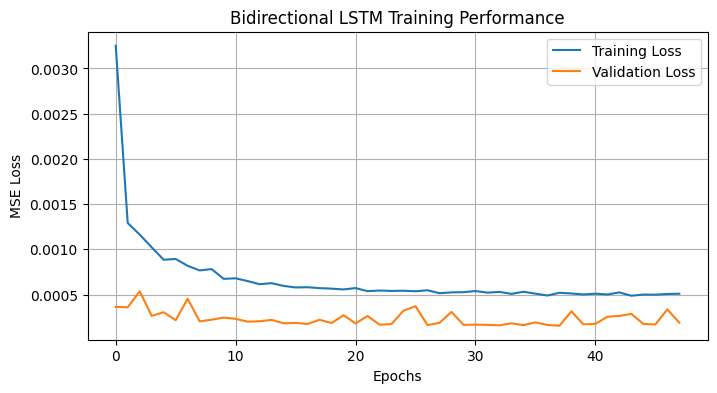

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


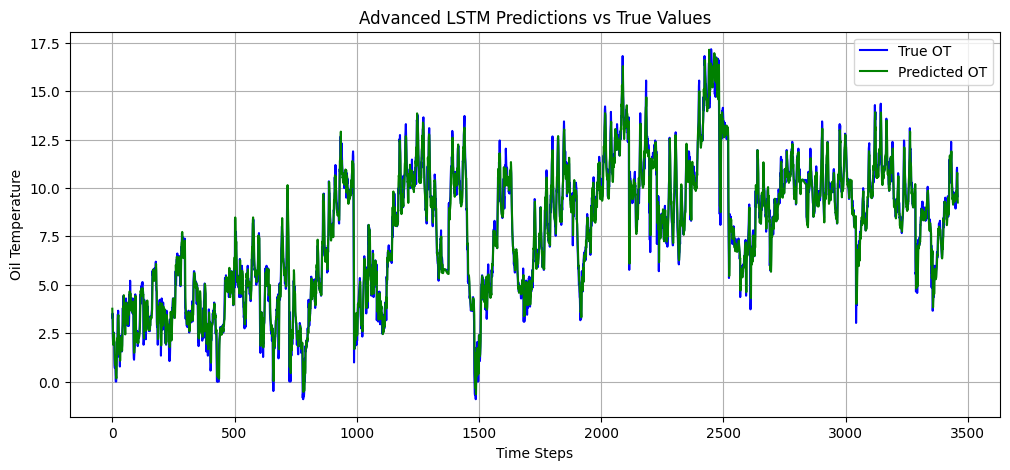

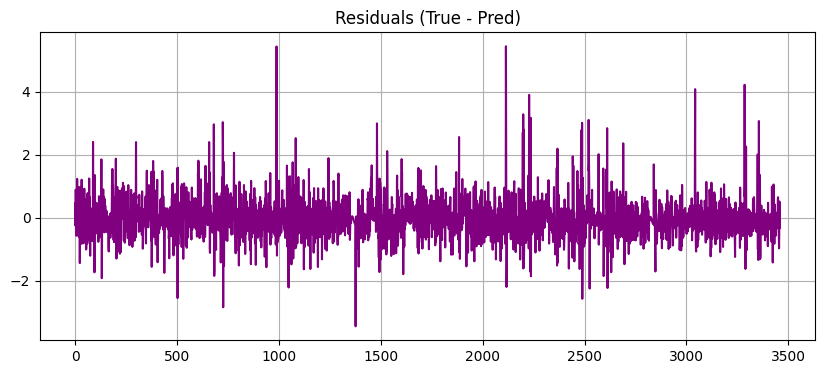

Total Area = 1504.9029433811088
Area + = 792.4565489785755
Area - = -712.4463944025332


In [63]:
# ---------------------------
# 5. Build Bidirectional_LSTM model
# ---------------------------
input_shape = (SEQ_LEN, X_train_simple.shape[2])
inputs = Input(shape=input_shape)
x = Bidirectional(LSTM(100, return_sequences=True))(inputs)
x = Dropout(0.2)(x)
x = LSTM(100)(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

Bidirectional_lstm = Model(inputs, outputs)
Bidirectional_lstm.compile(optimizer="adam", loss="mse", metrics=["mae"])

Bidirectional_lstm.summary()

# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train model
history_Bidirectional_lstm_simple = Bidirectional_lstm.fit(
    X_train_simple,
    y_train_simple,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test_simple, y_test_simple),
    callbacks=[early_stop],
    verbose=1,
)

# Plot training history
plt.figure(figsize=(8, 4))
plt.plot(history_Bidirectional_lstm_simple.history["loss"], label="Training Loss")
plt.plot(history_Bidirectional_lstm_simple.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Bidirectional LSTM Training Performance")
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
y_pred_scaled_Bidirectional_lstm = Bidirectional_lstm.predict(X_test_simple)
y_pred_Bidirectional_lstm_simple_true = scaler_y.inverse_transform(
    y_pred_scaled_Bidirectional_lstm.reshape(-1, 1)
).flatten()

# Plot predictions vs true values
plt.figure(figsize=(12, 5))
plt.plot(y_test_simple_true, label="True OT", color="blue")
plt.plot(y_pred_Bidirectional_lstm_simple_true, label="Predicted OT", color="green")
plt.xlabel("Time Steps")
plt.ylabel("Oil Temperature")
plt.title("Advanced LSTM Predictions vs True Values")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
res = y_pred_Bidirectional_lstm_simple_true.squeeze() - y_test_simple_true.squeeze()
plt.plot(res, color="purple")
plt.title("Residuals (True - Pred)")
plt.grid(True)
plt.show()

res = y_test_simple_true.squeeze() - y_pred_Bidirectional_lstm_simple_true.squeeze()
area_total_Bidirectional_lstm_simple = np.trapezoid(np.abs(res))
print("Total Area =", area_total_Bidirectional_lstm_simple)
area_positive_Bidirectional_lstm_simple = np.trapezoid(np.clip(res, 0, None))
area_negative_Bidirectional_lstm_simple = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_Bidirectional_lstm_simple)
print("Area - =", area_negative_Bidirectional_lstm_simple)

# LSTM_VMD

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 24, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_44 (LSTM)                  │ (None, 24, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_45 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,881 (792.50 KB)

 Trainable params: 202,881 (792.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0043 - mae: 0.0416 - val_loss: 3.9052e-04 - val_mae: 0.0143
Epoch 2/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0015 - mae: 0.0295 - val_loss: 3.6991e-04 - val_mae: 0.0139
Epoch 3/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0013 - mae: 0.0268 - val_loss: 2.8826e-04 - val_mae: 0.0123
Epoch 4/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 3.4847e-04 - val_mae: 0.0137
Epoch 5/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 9.7664e-04 - mae: 0.0236 - val_loss: 3.9687e-04 - val_mae: 0.0163
Epoch 6/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 9.3368e-04 - mae: 0.0227 - val_loss: 2.3804e-04 - val_mae: 0.0109
Epoch 7/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 9.2403e-04 - mae: 0.0227 - val_loss: 2.3459e-04 - val_mae: 0.0110
Epoch 8/50
435/435 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.4484e-04 - mae: 0.0217 - val_loss: 2.4270e-04 - val_mae: 0.0116


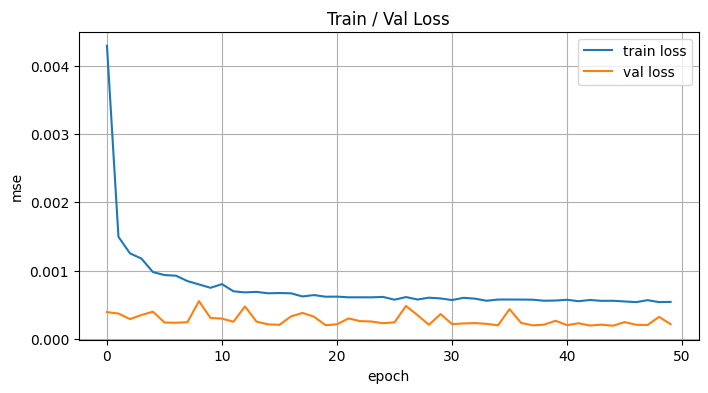

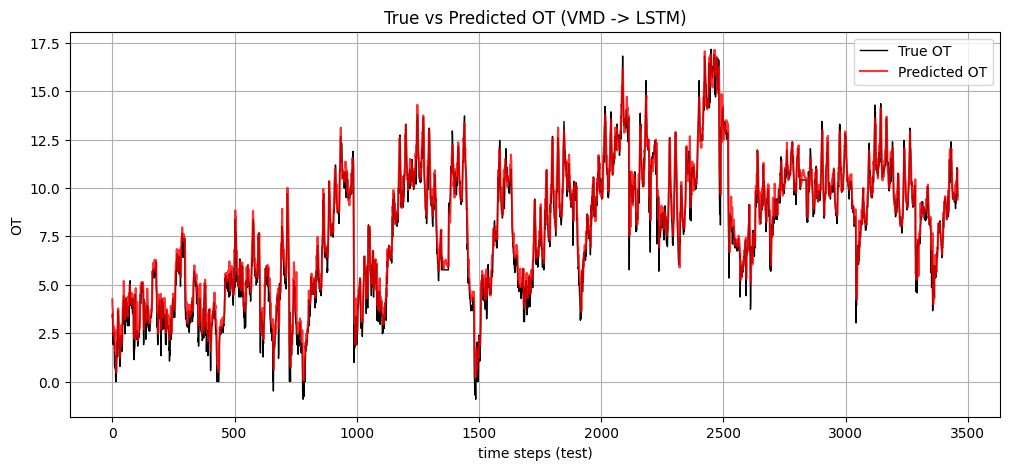

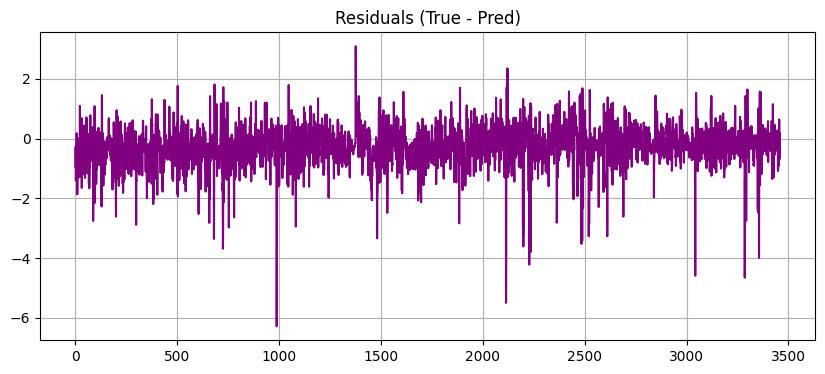

Total Area = 1801.8650919347997
Area + = 410.91793248057417
Area - = -1390.9471594542256


In [44]:
# ---------------------------
# 5. Build LSTM model
# ---------------------------
SEQ_LEN = X_train_vmd_scaled.shape[1]
N_FEATURES = X_train_vmd_scaled.shape[2]

inputs = Input(shape=(SEQ_LEN, N_FEATURES))

x = LSTM(128, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = LSTM(128)(x)
x = Dropout(0.2)(x)
outputs = Dense(1)(x)

model_lstm_model = Model(inputs, outputs)
model_lstm_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model_lstm_model.summary()

# ---------------------------
# 6. Train
# ---------------------------
history_lstm_vmd = model_lstm_model.fit(
    X_train_vmd_scaled,
    y_train_vmd_scaled,
    validation_data=(X_test_vmd_scaled, y_test_vmd_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
)

# ---------------------------
# 7. Predict & inverse-transform
# ---------------------------
y_pred_lstm_vmd_scaled = model_lstm_model.predict(X_test_vmd_scaled)
y_pred_lstm_vmd_true = scaler_y.inverse_transform(y_pred_lstm_vmd_scaled).flatten()

# ---------------------------
# 9. Plots
# ---------------------------
plt.figure(figsize=(8, 4))
plt.plot(history_lstm_vmd.history["loss"], label="train loss")
plt.plot(history_lstm_vmd.history["val_loss"], label="val loss")
plt.xlabel("epoch")
plt.ylabel("mse")
plt.legend()
plt.grid(True)
plt.title("Train / Val Loss")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_test_vmd_true, label="True OT", color="black", linewidth=1)
plt.plot(y_pred_lstm_vmd_true, label="Predicted OT", color="red", alpha=0.8)
plt.xlabel("time steps (test)")
plt.ylabel("OT")
plt.title("True vs Predicted OT (VMD -> LSTM)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
res = y_test_vmd_true - y_pred_lstm_vmd_true
plt.plot(res, color="purple")
plt.title("Residuals (True - Pred)")
plt.grid(True)
plt.show()

res = y_test_vmd_true.squeeze() - y_pred_lstm_vmd_true
area_total_lstm_vmd = np.trapezoid(np.abs(res))
print("Total Area =", area_total_lstm_vmd)
area_positive_lstm_vmd = np.trapezoid(np.clip(res, 0, None))
area_negative_lstm_vmd = np.trapezoid(np.clip(res, None, 0))
print("Area + =", area_positive_lstm_vmd)
print("Area - =", area_negative_lstm_vmd)

# Compare Models

In [28]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def compute_metrics(y_true, y_pred):
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2


# Compute metrics
mse_Attlstm_vmd, rmse_Attlstm_vmd, mae_Attlstm_vmd, r2_attlstm_vmd = compute_metrics(
    y_pred_attlstm_vmd_true, y_test_vmd_true
)
(
    mse_TAttlstm_vmd,
    rmse_TAttlstm_vmd,
    mae_TAttlstm_vmd,
    r2_Tattlstm_vmd,
) = compute_metrics(y_pred_Tattlstm_vmd_true, y_test_vmd_true)
(
    mse_TFTAttlstm_vmd,
    rmse_TFTAttlstm_vmd,
    mae_TFTAttlstm_vmd,
    r2_TFTattlstm_vmd,
) = compute_metrics(y_pred_TFTattlstm_vmd_true, y_test_vmd_true)
(
    mse_Lstm_Bidirectional_simple,
    rmse_Lstm_Bidirectional_simple,
    mae_Lstm_Bidirectional_simple,
    r2_Lstm_Bidirectional_simple,
) = compute_metrics(y_pred_Bidirectional_lstm_simple_true, y_test_simple_true)
(
    mse_Attlstm_simple,
    rmse_Attlstm_simple,
    mae_Attlstm_simple,
    r2_attlstm_simple,
) = compute_metrics(y_pred_attlstm_simple_true, y_test_simple_true)
mse_Lstm_vmd, rmse_Lstm_vmd, mae_Lstm_vmd, r2_Lstm_vmd = compute_metrics(
    y_pred_lstm_vmd_true, y_test_vmd_true
)

# Print comparison
print("📈 Model Performance Comparison")
print(
    f"ATT-LSTM-VMD: MSE={mse_Attlstm_vmd:.4f}, RMSE={rmse_Attlstm_vmd:.4f}, MAE={mae_Attlstm_vmd:.4f}, R²={r2_attlstm_vmd:.4f}, total_area={area_total_attlstm_vmd:.4f}"
)
print(
    f"TATT-LSTM-VMD: MSE={mse_TAttlstm_vmd:.4f}, RMSE={rmse_TAttlstm_vmd:.4f}, MAE={mae_TAttlstm_vmd:.4f}, R²={r2_Tattlstm_vmd:.4f}, total_area={area_total_Tattlstm_vmd:.4f}"
)
print(
    f"TFTATT-LSTM-VMD: MSE={mse_TFTAttlstm_vmd:.4f}, RMSE={rmse_TFTAttlstm_vmd:.4f}, MAE={mae_TFTAttlstm_vmd:.4f}, R²={r2_TFTattlstm_vmd:.4f}, total_area={area_total_TFTattlstm_vmd:.4f}"
)
print(
    f"Bidirectional_Lstm_Simple: MSE={mse_Lstm_Bidirectional_simple:.4f}, RMSE={rmse_Lstm_Bidirectional_simple:.4f}, MAE={mae_Lstm_Bidirectional_simple:.4f}, R²={r2_Lstm_Bidirectional_simple:.4f}, total_area={area_total_Bidirectional_lstm_simple:.4f}"
)
print(
    f"Attlstm_Simple: MSE={mse_Attlstm_simple:.4f}, RMSE={rmse_Attlstm_simple:.4f}, MAE={mae_Attlstm_simple:.4f}, R²={r2_attlstm_simple:.4f}, total_area={area_total_attlstm_simple:.4f}"
)
print(
    f"Lstm_vmd: MSE={mse_Lstm_vmd:.4f}, RMSE={rmse_Lstm_vmd:.4f}, MAE={mae_Lstm_vmd:.4f}, R²={r2_Lstm_vmd:.4f}, total_area={area_total_lstm_vmd:.4f}"
)

📈 Model Performance Comparison
ATT-LSTM-VMD: MSE=0.6866, RMSE=0.8286, MAE=0.6434, R²=0.9357, total_area=2225.9058
TATT-LSTM-VMD: MSE=0.6281, RMSE=0.7925, MAE=0.5990, R²=0.9491, total_area=2072.4574
TFTATT-LSTM-VMD: MSE=0.9493, RMSE=0.9743, MAE=0.7686, R²=0.9007, total_area=2658.3283
Bidirectional_Lstm_Simple: MSE=0.4345, RMSE=0.6592, MAE=0.4556, R²=0.9611, total_area=1575.7576
Attlstm_Simple: MSE=0.5235, RMSE=0.7236, MAE=0.5230, R²=0.9506, total_area=1809.2817
Lstm_vmd: MSE=0.6006, RMSE=0.7750, MAE=0.5829, R²=0.9513, total_area=2016.9031


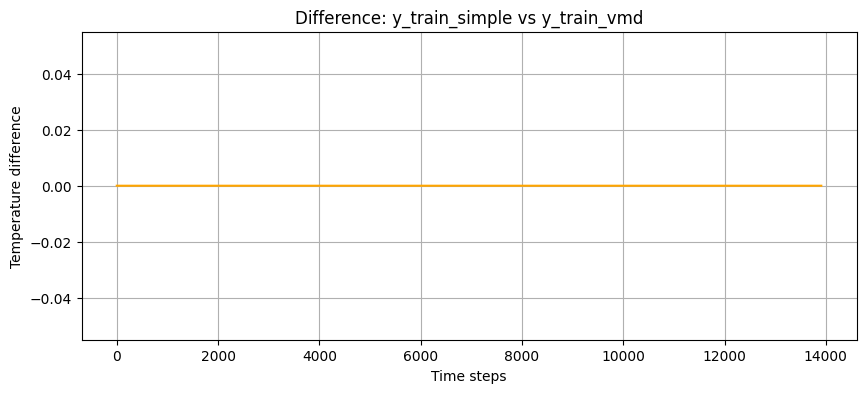

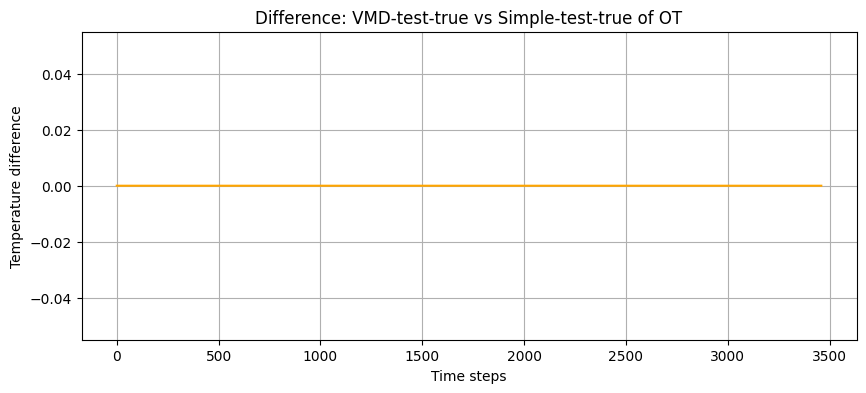

In [25]:
diff = y_train_simple_scaled - y_train_vmd_scaled
plt.figure(figsize=(10, 4))
plt.plot(diff, color="orange")
plt.title("Difference: y_train_simple vs y_train_vmd")
plt.xlabel("Time steps")
plt.ylabel("Temperature difference")
plt.grid(True)
plt.show()

y_test_vmd_true = scaler_y.inverse_transform(y_test_vmd_scaled)
y_test_simple_true = scaler_y.inverse_transform(y_test_simple_scaled)
diff = y_test_simple_true - y_test_vmd_true
plt.figure(figsize=(10, 4))
plt.plot(diff, color="orange")
plt.title("Difference: VMD-test-true vs Simple-test-true of OT")
plt.xlabel("Time steps")
plt.ylabel("Temperature difference")
plt.grid(True)
plt.show()